# Mod 2 Project
Use multivariate linear regression to predict housing prices for the King County, WA Dataset

https://en.wikipedia.org/wiki/King_County,_Washington

https://www.kingcounty.gov/depts/assessor.aspx

## Imports

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import scale

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

from haversine import haversine

## Read in Data

In [2]:
df = pd.read_csv('datasets/kc_house_data.csv')

## EDA

EDA was done in a separate notebook.  EDA.ipynb

Any pre-processing done during EDA is placed in the function below.

### pre-process data

based upon the datatype conversions, and NaN value processing above

In [3]:
def pre_process_data(data):
    """Convert String columns to numeric/data, and fill Nan values"""
    # type conversion
    data.loc[data.sqft_basement == '?', 'sqft_basement'] = '0'
    data.sqft_basement = data.sqft_basement.astype(float)
    
    data.date = pd.to_datetime(data.date)
    
    # fill Nan values
    data.waterfront.fillna(0.0, inplace=True)
    data.view.fillna(0.0, inplace=True)
    data.yr_renovated.fillna(0.0, inplace=True)
    
    # drop 'bad data'
    data.drop_duplicates(subset='id', keep='last', inplace=True)
    data.drop(data[data.bedrooms == 33].index, inplace=True)
    data.drop(data[data.id == 2991000160].index, inplace=True)
    
    return data

In [4]:
df_clean = pre_process_data(df)

#### Analysis

## Categorical Features

Normally the categorical features would be dealt with after a test train split has been done, but with the tools available for this project, it must be done before the split so that all the categories can be made.

### Category Helper Functions

In [5]:
def df_ohe(data, col, prefix=''):
    """
    Create One Hot Encoded (OHE) features for a column and 
    return the updated dataframe
    
    Parameters:
    data: dataframe
    col: column in dataframe for OHE process
    prefix: prefix to add the the new columns
    """
    dummies = pd.get_dummies(data[col],
                            prefix=prefix,
                            drop_first=True)
    data = data.drop(col, axis=1)
    data = pd.concat([data, dummies], axis=1)
    return data

In [6]:
def make_category(data, col):
    """
    Make a dataframe column a category and perform a One Hot Encoding on it,
    and return the updated dataframe
    
    Parameters:
    data: dataframe
    col: column in dataframe for OHE process
    prefix: prefix to add the the new columns
    
    """
    suffix='_encoded'
    lb_make = LabelEncoder()
    data[col] = data[col].astype('category')
    data[col+suffix] = lb_make.fit_transform(data[col])
    data = data.drop(col, axis=1)
    data = df_ohe(data, col+suffix, col+'_')
    return data

In [7]:
def define_bins(data, col, num_quantiles):
    """
    Define bins for a dataframe column based on a number of quantiles
    
    Parameters:
    data: dataframe
    col: column to be binned
    num_quantiles: number of quantiles for binning
    """
    
    q_interval = 1 / num_quantiles
    print(q_interval)
    current_q = 0
    quantile_list = []
    
    for q in range(num_quantiles + 1):
        quantile_list.append(current_q)
        current_q = round(current_q + q_interval, 2)
    print(quantile_list)
    quantiles = data[col].quantile(quantile_list)
    
    return quantiles

In [8]:
def visualize_bins(data, col, quantiles):
    """
    Produce a histogram showing quantile splits
    
    Parameters:
    data: dataframe
    col: column
    quantiles: values for each quantile in col
    """
    fig, ax = plt.subplots()
    data[col].hist(bins='auto', color='#A9C5D3', 
                                 edgecolor='black', grid=False)
    for quantile in quantiles:
        qvl = plt.axvline(quantile, color='r')
    ax.legend([qvl], ['Quantiles'], fontsize=10)

In [9]:
def create_bins(data, col, bins):
    """
    Bin and One Hot Encode a dataframe column, and return the updated dataframe
    
    Parameters:
    data: dataframe
    col: column
    bins: array of where to split the data in col
    """
    
    col_binned = pd.cut(data[col], bins)
    binned_name = col+'_binned'
    data[binned_name] = col_binned
    data = data.drop(col, axis=1)
    data = df_ohe(data, binned_name, col)
    
    return data

### Simple Categories

In [10]:
simple_cat_data_cols = ['view','waterfront']

In [11]:
for col in simple_cat_data_cols:
    df_clean = make_category(df_clean, col)

### Complex Categories

#### yr_renovated and yr_built - had_reno

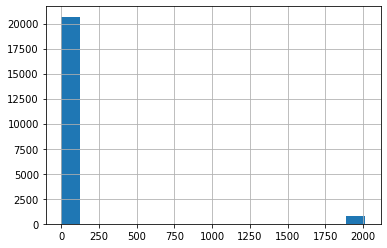

In [12]:
df_clean.yr_renovated.hist(bins='auto')

In [13]:
renovated_houses = df_clean[df_clean.yr_renovated >= df_clean.yr_built.min()]

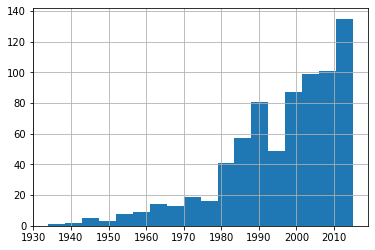

In [14]:
renovated_houses.yr_renovated.hist(bins='auto')

In [15]:
len(renovated_houses)

740

In [16]:
renovated_houses.id.nunique()

740

In [17]:
renovated_houses.id.value_counts()

2804100095    1
2131701075    1
1556200155    1
3179101580    1
3323069045    1
             ..
7950302890    1
6430000275    1
3450300280    1
9201000100    1
9297300480    1
Name: id, Length: 740, dtype: int64

There are very few renovated houses in the dataset, but it is potentially valuable info for those houses.

I will create a two new features
* yr_updated that will be the year built or the most recent renovation, which will be binned into 4 quantiles
* had_reno that will be a boolean indicating if a renovation ever occurred

yr_renovated and yr_built will not be included in the model

In [18]:
def had_reno(yr_renovated):
    """Return 0 if no renovation, 1 otherwise"""
    if yr_renovated == 0:
        return 0
    else:
        return 1

In [19]:
df_clean['had_reno'] = df_clean.yr_renovated.apply(had_reno)

In [20]:
df_clean = make_category(df_clean, 'had_reno')

In [21]:
def get_year_updated(row):
    """ Return the newer of yr_built or yr_renovated for a row"""
    if (row['yr_renovated'] == 0):
        year = row['yr_built']
    else:
        year = row['yr_renovated']
    
    return year

In [22]:
df_clean['yr_updated'] = df_clean.apply(get_year_updated, axis=1)

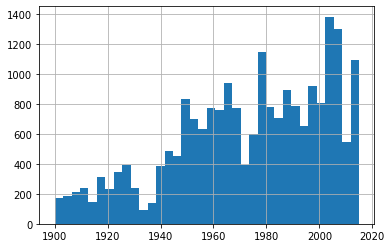

In [23]:
df_clean.yr_updated.hist(bins='auto')

In [24]:
yr_updated_bins = define_bins(df_clean, 'yr_updated', 4)

0.25
[0, 0.25, 0.5, 0.75, 1.0]


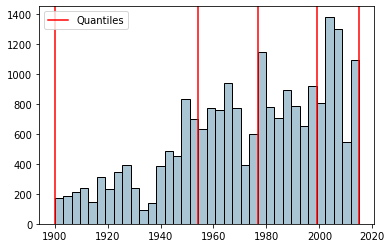

In [25]:
visualize_bins(df_clean, 'yr_updated', yr_updated_bins)

In [26]:
df_clean = create_bins(df_clean, 'yr_updated', yr_updated_bins)

#### Condition

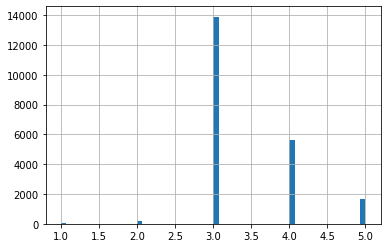

In [27]:
df_clean.condition.hist(bins='auto')

In [28]:
df_clean.condition.value_counts()

3    13899
4     5643
5     1686
2      162
1       28
Name: condition, dtype: int64

In [29]:
df_clean = df_ohe(df_clean, 'condition', 'condition')

#### zipcode

In [30]:
df_clean = df_ohe(df_clean, 'zipcode')

#### Latitude

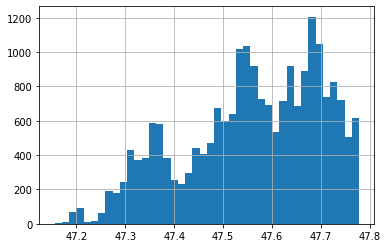

In [31]:
df_clean.lat.hist(bins='auto')

0.05
[0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0]


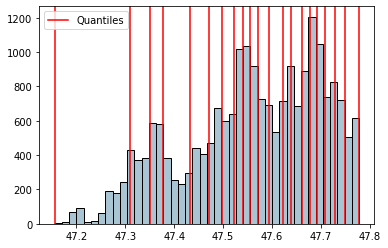

In [32]:
lat_bins = define_bins(df_clean, 'lat', 20)
visualize_bins(df_clean, 'lat', lat_bins)

In [33]:
# df_clean = create_bins(df_clean, 'lat', lat_bins)

#### Longitude

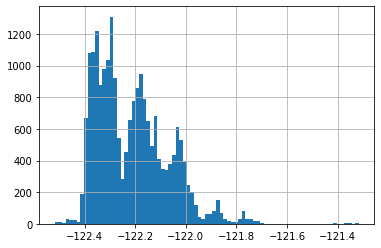

In [34]:
df_clean.long.hist(bins='auto')

0.05
[0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0]


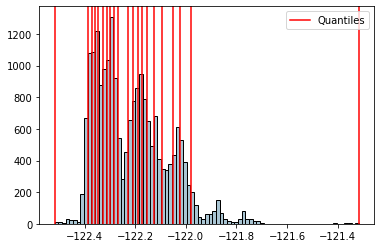

In [35]:
long_bins = define_bins(df_clean, 'long', 20)
visualize_bins(df_clean, 'long', long_bins)

In [36]:
# df_clean = create_bins(df_clean, 'long', long_bins)

#### Date

While the sale date does not have a correlation witht the sale price, 
it seems probable that houses on the waterfront would sell better in 
warmer months.

I will create a new feature called season by extracting it from the sale date.

In [37]:
df_clean['sale_month'] = df_clean.date.apply(lambda date: date.month)

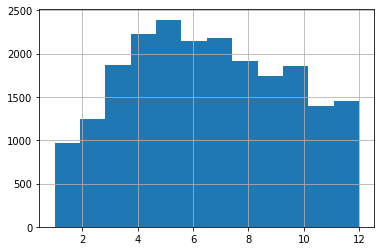

In [38]:
df_clean['sale_month'].hist(bins=12)

In [39]:
df_clean['sale_month'].value_counts()

5     2393
4     2229
7     2187
6     2150
8     1913
3     1875
10    1854
9     1747
12    1457
11    1396
2     1244
1      973
Name: sale_month, dtype: int64

In [40]:
def make_season(month):
    """Return a category value based on month"""
    winter = (11, 12, 1, 2)
    spring = (3, 4, 5, 6)
    summer = (7, 8, 9, 10)
    if month in winter:
        cat = 0
    elif month in spring:
        cat = 1
    else:
        cat = 2
        
    return cat

In [41]:
df_clean['season'] = df_clean.sale_month.apply(lambda month: make_season(month))

In [42]:
df_clean = make_category(df_clean, 'season')

In [43]:
df_clean = df_clean.drop('sale_month', axis=1)

#### Floors - Split Level Flag

In [44]:
def in_split_level(floors):
    """Return whether the number of floors indicates a split level house"""
    split_levels = {1.5, 2.5, 3.5}
    if floors in split_levels:
        return 0
    else:
        return 1

df_clean['split_level'] = df_clean.floors.apply(in_split_level)


In [45]:
df_clean = make_category(df_clean, 'split_level')

#### sqft_basement - Flag

In [46]:
def has_basement(sqft_basement):
    """Return whether the house has a basement"""
    if sqft_basement == 0.0:
        return 0
    else:
        return 1

df_clean['has_basement'] = df_clean.sqft_basement.apply(has_basement)

df_clean = make_category(df_clean, 'has_basement')


## New Continuous Features

### Distance from City Center

calculate the distance from the center of the major cities in King County and store the min distance

In [47]:
# calculate the distance from the center of the major cities in King County
df_clean['lat_long'] = tuple(zip(df_clean.lat, df_clean.long))
    
seattle = [47.6092,-122.3363]
bellevue = [47.61555,-122.20392]
kirkland = [47.6769, -122.2060]
redmond = [47.6740, -122.1215]

def calc_distances(lat_long, city):
    dists = []
    for loc in lat_long:
        dists.append(haversine((city),(loc),unit='mi'))
    return pd.Series(dists, index=df_clean.index)

df_clean['d_from_s'] = calc_distances(df_clean['lat_long'], seattle)
df_clean['d_from_b'] = calc_distances(df_clean['lat_long'], bellevue)
df_clean['d_from_k'] = calc_distances(df_clean['lat_long'], kirkland)
df_clean['d_from_r'] = calc_distances(df_clean['lat_long'], redmond)

df_clean['dist_from_city'] = df_clean[['d_from_b', 'd_from_s', 'd_from_k', 'd_from_r']].min(axis=1, numeric_only=True)

df_clean.drop(['d_from_b', 'd_from_s', 'd_from_k', 'd_from_r', 'lat_long'], axis=1, inplace=True)

## Model Helper Functions

In [48]:
def lin_reg_sklearn(X_train, X_test, y_train, y_test, drop_list=[]):
    """
    Perform a Linear Regression with SK Learn and output 
    RMSE from the test and training sets, plus a cross validation of the training set.
    """
    
    lin_reg = LinearRegression()
    lin_reg.fit(X_train, y_train)

    y_hat_train = lin_reg.predict(X_train)
    y_hat_test = lin_reg.predict(X_test)

    y_hat_train = lin_reg.predict(X_train)
    y_hat_test = lin_reg.predict(X_test)

    train_mse = mean_squared_error(y_train, y_hat_train)
    test_mse = mean_squared_error(y_test, y_hat_test)

    print(f'Training Set RMSE: {np.sqrt(train_mse)}')
    print(f'Test Set RMSE: {np.sqrt(test_mse)}')

    MSE = make_scorer(mean_squared_error)

    cv_rmse = np.sqrt(np.mean(cross_val_score(lin_reg, X_train, 
                                                    y_train, cv=10,
                                                   scoring=MSE)))
    print(f'Cross Val RMSE: {cv_rmse}')

In [49]:
def lin_reg_statsmodels(X_train, y_train, drop_list=[]):
    """
    Perform a Linear Regression with Statsmodels, output the summary and
    return the model
    """
    
    X_train_int = sm.add_constant(X_train)
    model = sm.OLS(y_train, X_train_int).fit()
    display(model.summary())
    
    return model

In [50]:
def drop_features(X_train, X_test, drop_list):
    """
    Drop features in the drop_list from the two dataframes and return
    the two updated dataframes
    """
    if len(drop_list) >= 1:
        X_train = X_train.drop(drop_list, axis=1)
        X_test = X_test.drop(drop_list, axis=1)
    
    return X_train, X_test

In [51]:
def regression_plots(data, model):
    """Regression plots for the features in the data dataframe based on the model"""
    for col in data.columns:
        fig = plt.figure(figsize=(16,12))
        sm.graphics.plot_regress_exog(model, col, fig=fig)
        fig.show()

In [52]:
def vif_analysis(data):
    """VIF analysis on the data dataframe"""
    for i in range(len(data.columns)):
        v=vif(np.matrix(data),i)
        print("Variance inflation factor for {}: {}".format(data.columns[i],round(v,2)))

In [53]:
def BidirectionalStepwiseSelection(X, y, model_type ="linear", elimination_criteria = "aic", varchar_process = "dummy_dropfirst", senter=0.05, sstay=0.05):
    
    """
    Forward Selection is a function, based on regression models, that returns significant features and selection iterations.\n
    Required Libraries: pandas, numpy, statmodels
    
    Parameters
    ----------
    X : Independent variables (Pandas Dataframe)\n
    y : Dependent variable (Pandas Series, Pandas Dataframe)\n
    model_type : 'linear' or 'logistic'\n
    elimination_criteria : 'aic', 'bic', 'r2', 'adjr2' or None\n
        'aic' refers Akaike information criterion\n
        'bic' refers Bayesian information criterion\n
        'r2' refers R-squared (Only works on linear model type)\n
        'r2' refers Adjusted R-squared (Only works on linear model type)\n
    varchar_process : 'drop', 'dummy' or 'dummy_dropfirst'\n
        'drop' drops varchar features\n
        'dummy' creates dummies for all levels of all varchars\n
        'dummy_dropfirst' creates dummies for all levels of all varchars, and drops first levels\n
    senter : Significance Level to be Selected in Forward Selection (default: 0.05)\n
    sstay : Significance Level to be Stayed in Backward Elimination (default: 0.05)\n
  
    Returns
    -------
    columns(list), iteration_logs(str)\n\n
    Not Returns a Model
    
    Tested On
    ---------
    Python v3.6.7, Pandas v0.23.4, Numpy v1.15.04, StatModels v0.9.0
    
    See Also
    --------
    https://en.wikipedia.org/wiki/Stepwise_regression
    """  
    
    X = __varcharProcessing__(X,varchar_process = varchar_process)
    return __stepwiseSelectionRaw__(X, y, model_type = model_type,elimination_criteria = elimination_criteria , senter = senter, sstay = sstay)

def __varcharProcessing__(X, varchar_process = "dummy_dropfirst"):
    
    dtypes = X.dtypes
    if varchar_process == "drop":   
        X = X.drop(columns = dtypes[dtypes == np.object].index.tolist())
        print("Character Variables (Dropped):", dtypes[dtypes == np.object].index.tolist())
    elif varchar_process == "dummy":
        X = pd.get_dummies(X,drop_first=False)
        print("Character Variables (Dummies Generated):", dtypes[dtypes == np.object].index.tolist())
    elif varchar_process == "dummy_dropfirst":
        X = pd.get_dummies(X,drop_first=True)
        print("Character Variables (Dummies Generated, First Dummies Dropped):", dtypes[dtypes == np.object].index.tolist())
    else: 
        X = pd.get_dummies(X,drop_first=True)
        print("Character Variables (Dummies Generated, First Dummies Dropped):", dtypes[dtypes == np.object].index.tolist())
    
    X["intercept"] = 1
    cols = X.columns.tolist()
    cols = cols[-1:] + cols[:-1]
    X = X[cols]
    
    return X

def __stepwiseSelectionRaw__(X, y, model_type ="linear",elimination_criteria = "aic", senter=0.05, sstay=0.05):

    iterations_log = ""
    cols = X.columns.tolist()
    
    def regressor(y,X, model_type=model_type):
        if model_type == "linear":
            regressor = sm.OLS(y, X).fit()
        elif model_type == "logistic":
            regressor = sm.Logit(y, X).fit()
        else:
            print("\nWrong Model Type : "+ model_type +"\nLinear model type is seleted.")
            model_type = "linear"
            regressor = sm.OLS(y, X).fit()
        return regressor
    
    selected_cols = ["intercept"]
    other_cols = cols.copy()
    other_cols.remove("intercept")
    
    model = regressor(y, X[selected_cols])
    
    if elimination_criteria == "aic":
        criteria = model.aic
    elif elimination_criteria == "bic":
        criteria = model.bic
    elif elimination_criteria == "r2" and model_type =="linear":
        criteria = model.rsquared
    elif elimination_criteria == "adjr2" and model_type =="linear":
        criteria = model.rsquared_adj
    
    
    for i in range(X.shape[1]):
        pvals = pd.DataFrame(columns = ["Cols","Pval"])
        for j in other_cols:
            model = regressor(y, X[selected_cols+[j]])
            pvals = pvals.append(pd.DataFrame([[j, model.pvalues[j]]],columns = ["Cols","Pval"]),ignore_index=True)
        pvals = pvals.sort_values(by = ["Pval"]).reset_index(drop=True)
        pvals = pvals[pvals.Pval<= senter]
        if pvals.shape[0] > 0:
            
            model = regressor(y, X[selected_cols+[pvals["Cols"][0]]])
            iterations_log += "\n" + str(i+1) + ". iteration"
            iterations_log += str("\nEntered : "+pvals["Cols"][0] + "\n")    
            iterations_log += "\n\n"+str(model.summary())+"\nAIC: "+ str(model.aic) + "\nBIC: "+ str(model.bic)+"\n\n"
                    

            for k in range(X[selected_cols+[pvals["Cols"][0]]].shape[1]):
                
                cols_backward = X[selected_cols+[pvals["Cols"][0]]].columns.tolist()
                pvals_backward = pd.DataFrame(columns = ["bw_Cols","bw_Pval"])

 
                for l in cols_backward:
                    pvals_backward = pvals_backward.append(pd.DataFrame([[l, model.pvalues[l]]],columns= ["bw_Cols","bw_Pval"]),ignore_index=True)
                    
                pvals_backward = pvals_backward.sort_values(by = ["bw_Pval"]).reset_index(drop=True)
                pvals_backward_drop = pvals_backward[pvals_backward.bw_Pval > sstay].reset_index(drop=True)

                if pvals_backward_drop.shape[0] > 0:
                    
                    
                    iterations_log += str("\nBackward Step Dropped : "+pvals_backward_drop["bw_Cols"][0] + "\n") 
                        
                    if pvals_backward_drop["bw_Cols"][0] in other_cols:
                        other_cols.remove(pvals_backward_drop["bw_Cols"][0])
                    else:
                        pass    
                    
                    if pvals_backward_drop["bw_Cols"][0] in selected_cols:
                        selected_cols.remove(pvals_backward_drop["bw_Cols"][0])
                    else:
                        pass    
                           
                    model = regressor(y, X[selected_cols+[pvals["Cols"][0]]])
                    iterations_log += "\n\n"+str(model.summary())+"\nAIC: "+ str(model.aic) + "\nBIC: "+ str(model.bic)+"\n\n"     
        
           
                else:
                    print("break : No need to Backward Elimination")
                    break
            
            
            if  elimination_criteria == "aic":
                new_criteria = model.aic
                if new_criteria < criteria:
                    print("Entered :", pvals["Cols"][0], "\tAIC :", model.aic)
                    selected_cols.append(pvals["Cols"][0])
                    other_cols.remove(pvals["Cols"][0])
                    criteria = new_criteria
                else:
                    print("break : Criteria")
                    break
            elif  elimination_criteria == "bic":
                new_criteria = model.bic
                if new_criteria < criteria:
                    print("Entered :", pvals["Cols"][0], "\tBIC :", model.bic)
                    selected_cols.append(pvals["Cols"][0])
                    other_cols.remove(pvals["Cols"][0])
                    criteria = new_criteria
                else:
                    print("break : Criteria")
                    break        
            elif  elimination_criteria == "r2" and model_type =="linear":
                new_criteria = model.rsquared
                if new_criteria > criteria:
                    print("Entered :", pvals["Cols"][0], "\tR2 :", model.rsquared)
                    selected_cols.append(pvals["Cols"][0])
                    other_cols.remove(pvals["Cols"][0])
                    criteria = new_criteria
                else:
                    print("break : Criteria")
                    break           
            elif  elimination_criteria == "adjr2" and model_type =="linear":
                new_criteria = model.rsquared_adj
                if new_criteria > criteria:
                    print("Entered :", pvals["Cols"][0], "\tAdjR2 :", model.rsquared_adj)
                    selected_cols.append(pvals["Cols"][0])
                    other_cols.remove(pvals["Cols"][0])
                    criteria = new_criteria
                else:
                    print("Break : Criteria")
                    break
            else:
                print("Entered :", pvals["Cols"][0])
                selected_cols.append(pvals["Cols"][0])
                other_cols.remove(pvals["Cols"][0])            
            
        else:
            print("Break : Significance Level")
            break
        
    model = regressor(y, X[selected_cols])
    if elimination_criteria == "aic":
        criteria = model.aic
    elif elimination_criteria == "bic":
        criteria = model.bic
    elif elimination_criteria == "r2" and model_type =="linear":
        criteria = model.rsquared
    elif elimination_criteria == "adjr2" and model_type =="linear":
        criteria = model.rsquared_adj
    
    print(model.summary())
    print("AIC: "+str(model.aic))
    print("BIC: "+str(model.bic))
    print("Final Variables:", selected_cols)
    

    iterations_log += "\nFinal Selection and Model Statistics\n"
    
    for m in range(len(selected_cols)):
        iterations_log += "\n" + str(m+1) + str(". Final Variable :  "+ selected_cols[m]) 
           
    iterations_log += "\n\n"+str(model.summary())+"\nAIC: "+ str(model.aic) + "\nBIC: "+ str(model.bic)+"\n\n"


    return selected_cols, iterations_log

## Split the Data into train/test

In [54]:
y = df_clean.price
X = df_clean.drop('price', axis=1)

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)

## Drop Outliers in Training Data

In [56]:
def drop_outliers(data, col, n_std):
    return data[np.abs(data[col]-data[col].mean())<=(n_std*data[col].std())]

In [57]:
def outlier_val(data, col, n_std):
    return n_std*data[col].std()

## Simple Model

This will be the baseline model.  It will contain all of the continuous 
numerical features, but no others.

### Define feature sets

In [58]:
cont_data_cols = ['bathrooms', 'bedrooms', 'sqft_above', 'sqft_living15', 
                 'sqft_lot', 'sqft_lot15', 'floors', 'grade', 'dist_from_city']

In [59]:
X_train_cont_features = X_train[cont_data_cols]
X_test_cont_features = X_test[cont_data_cols]

### Linear Regression sklearn

In [60]:
lin_reg_sklearn(X_train_cont_features, X_test_cont_features, y_train, y_test)

Training Set RMSE: 229849.27838494506
Test Set RMSE: 230196.43811812272
Cross Val RMSE: 230266.44106813415


### Linear Regression statsmodels

In [61]:
model_cont_features = lin_reg_statsmodels(X_train_cont_features, y_train)

/Users/freethrall/anaconda3/envs/learn-env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.608
Model:                            OLS   Adj. R-squared:                  0.607
Method:                 Least Squares   F-statistic:                     2945.
Date:                Sat, 09 May 2020   Prob (F-statistic):               0.00
Time:                        20:23:43   Log-Likelihood:            -2.3583e+05
No. Observations:               17134   AIC:                         4.717e+05
Df Residuals:                   17124   BIC:                         4.718e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const          -3.032e+05   1.66e+04    -18.273      0.000   -3.36e+05   -2.71e+05
bathrooms       6.449e+04   3607.765     17.877      0.000    5.74e+04    7.16e+04
bedrooms       -1.357e+04   2413.668     -5.622      0.000   -1.83e+04   -8837.851
sqft_above       135.4991      4.197     32.288      0.000     127.273     143.725
sqft_living15     50.1571      4.159     12.060      0.000      42.005      58.309
sqft_lot           0.3158      0.064      4.949      0.000       0.191       0.441
sqft_lot15        -0.0236      0.095     -0.249      0.804      -0.209       0.162
floors         -1.005e+05   4125.507    -24.361      0.000   -1.09e+05   -9.24e+04
grade           9.536e+04   2643.763     36.069      0.000    9.02e+04    1.01e+05
dist_from_city -2.014e+04    283.308    -71.079      0.000   -2.07e+04   -1.96e+04
==============================================================================
Omnibus:                    17513.029   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          2665284.930
Skew:                           4.744   Prob(JB):                         0.00
Kurtosis:                      63.360   Cond. No.                     4.67e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.67e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Analyze the residuals

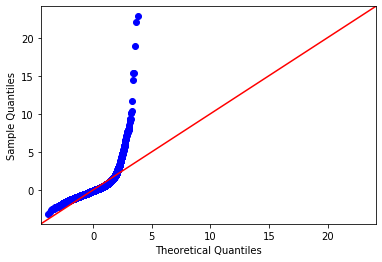

In [62]:
sm.graphics.qqplot(model_cont_features.resid, line='45', fit=True);

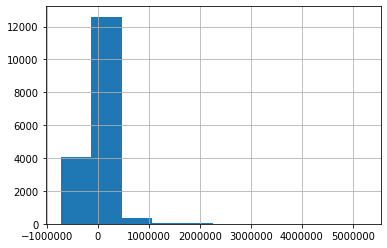

In [63]:
model_cont_features.resid.hist()

/Users/freethrall/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  after removing the cwd from sys.path.


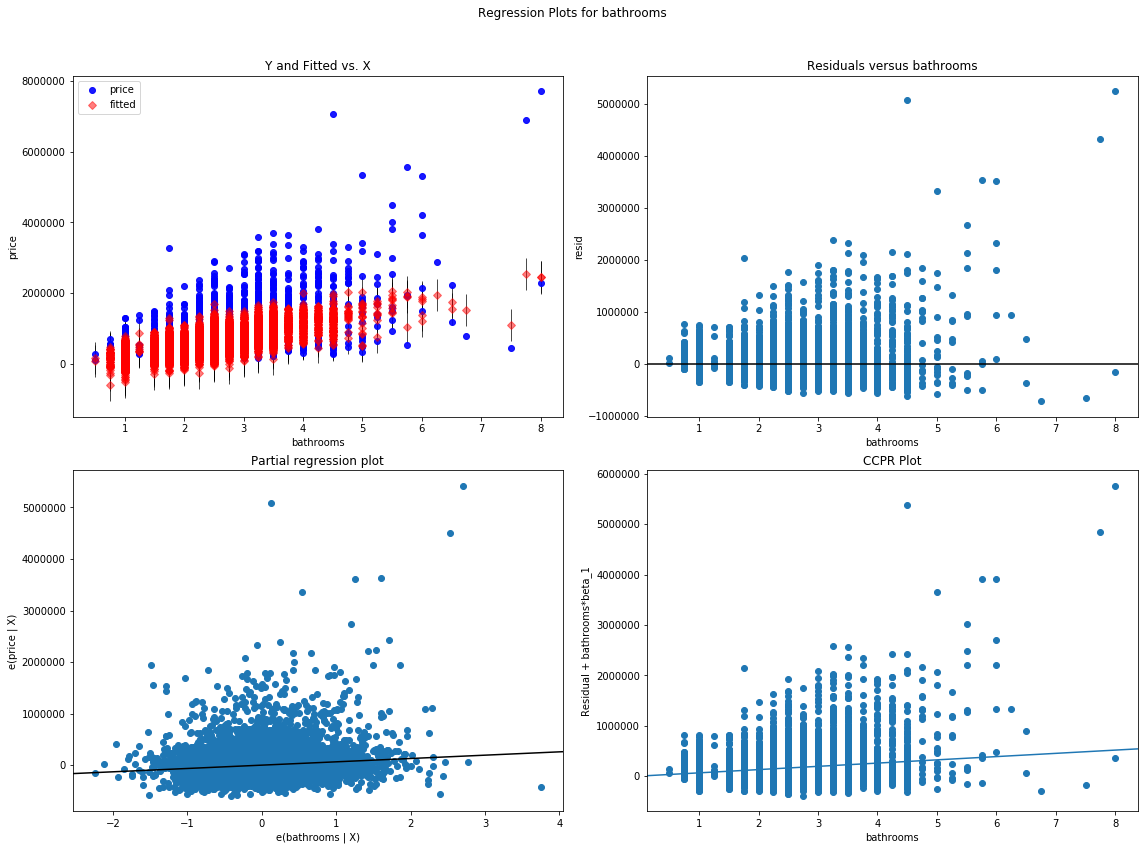

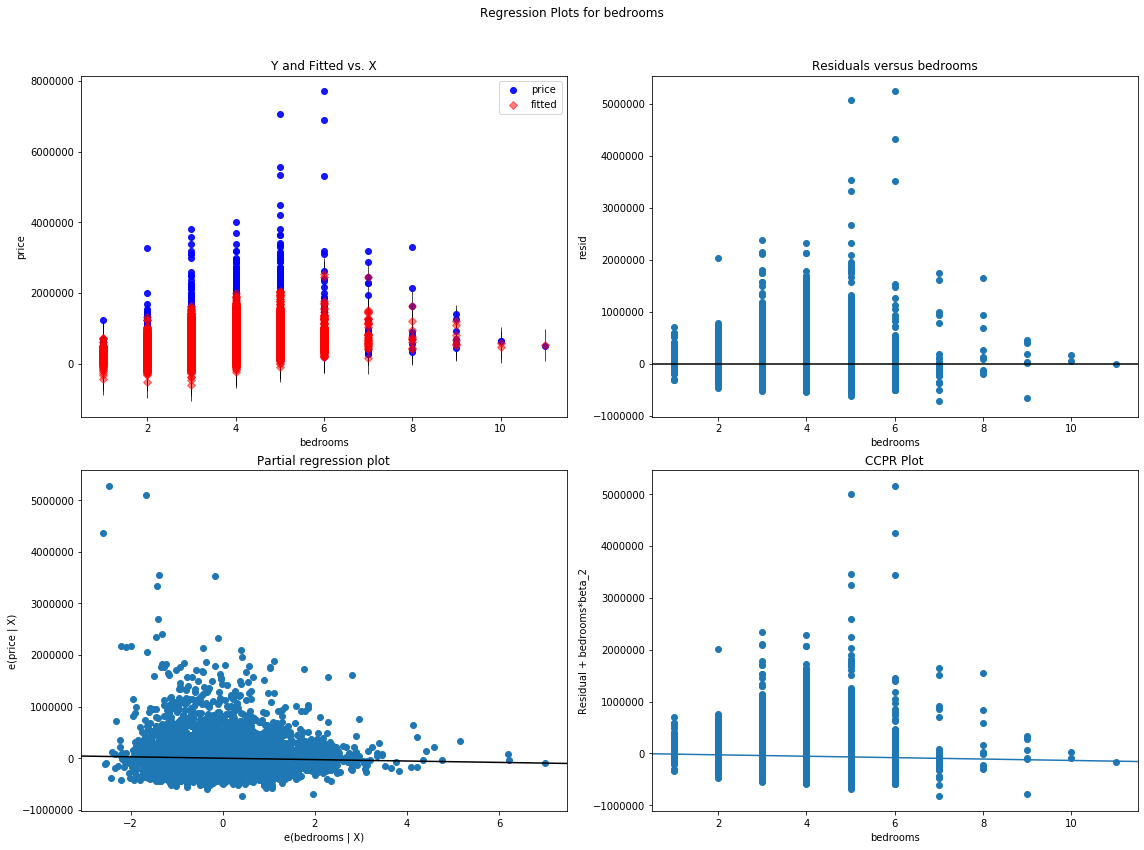

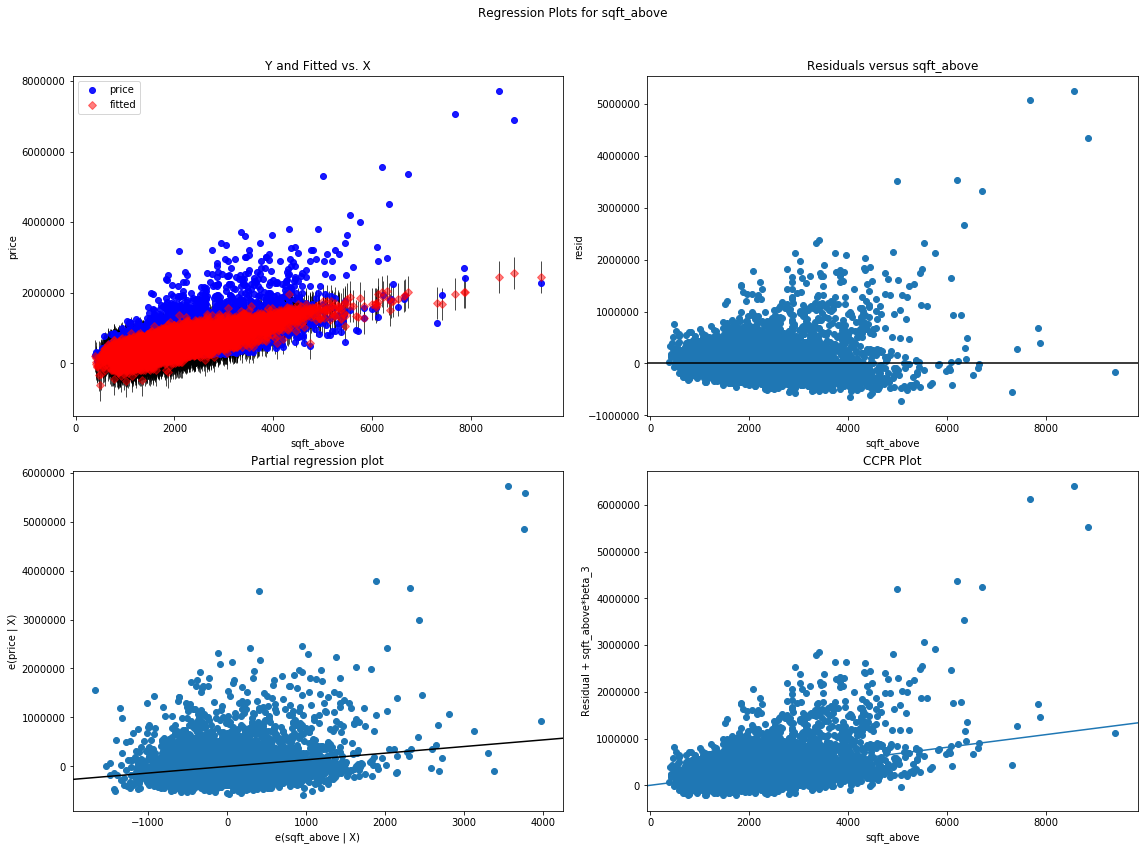

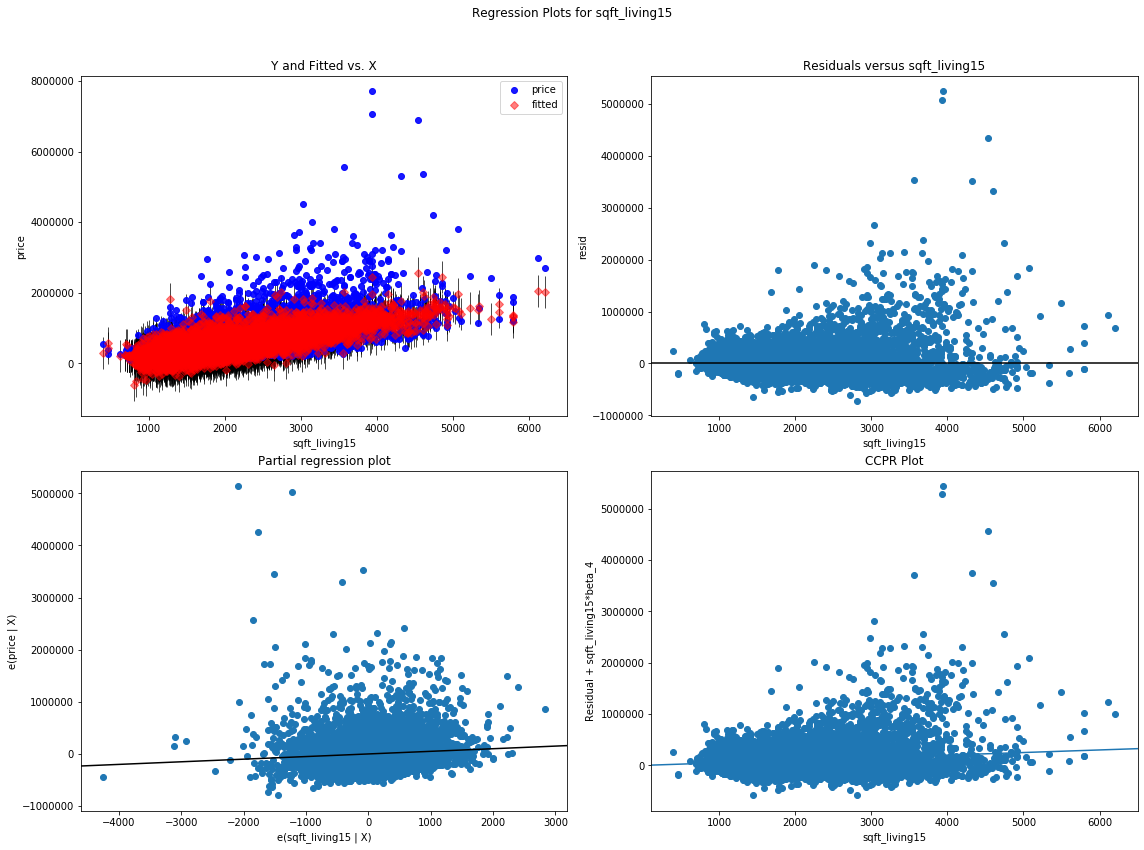

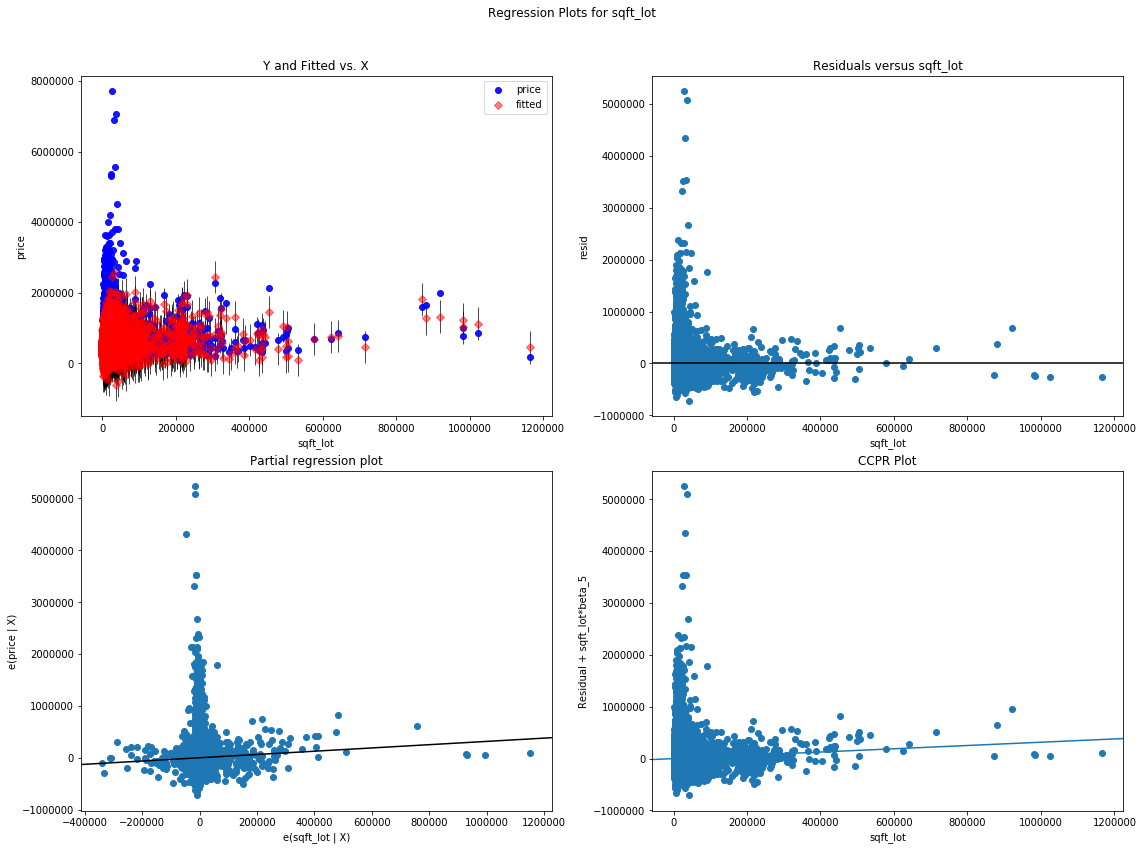

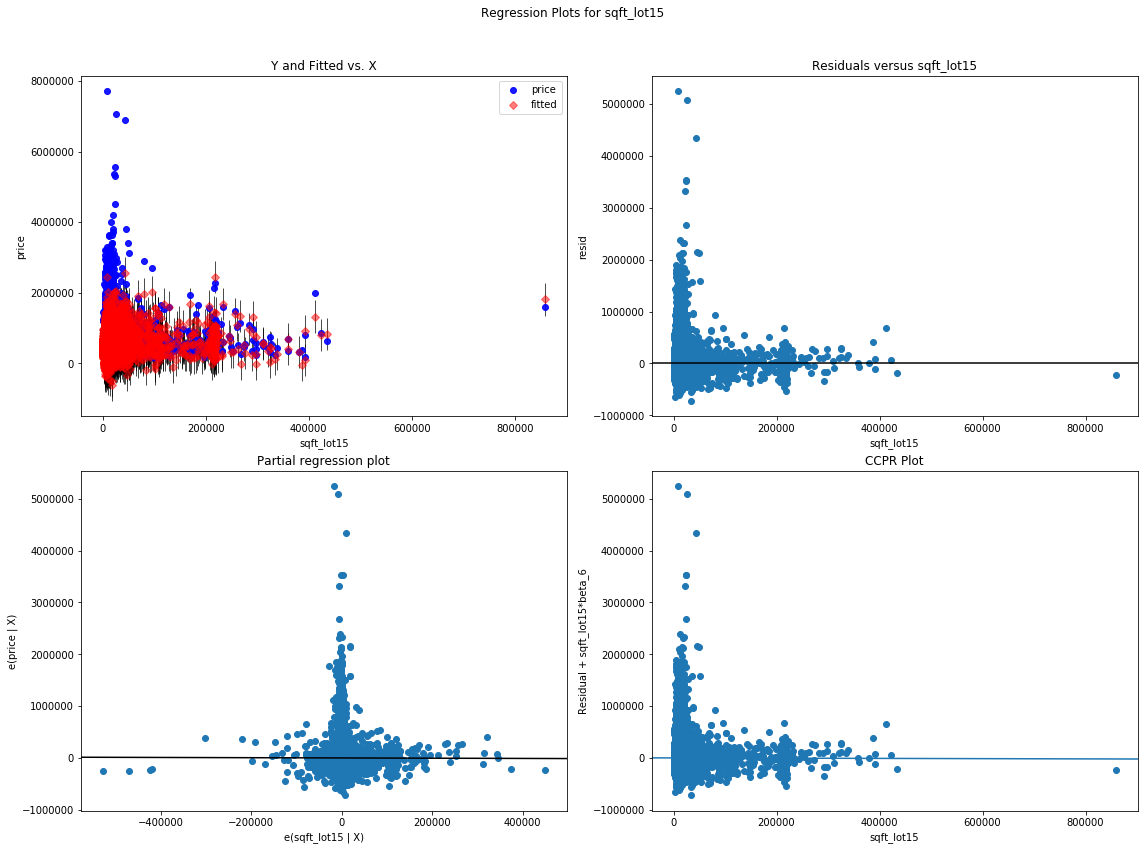

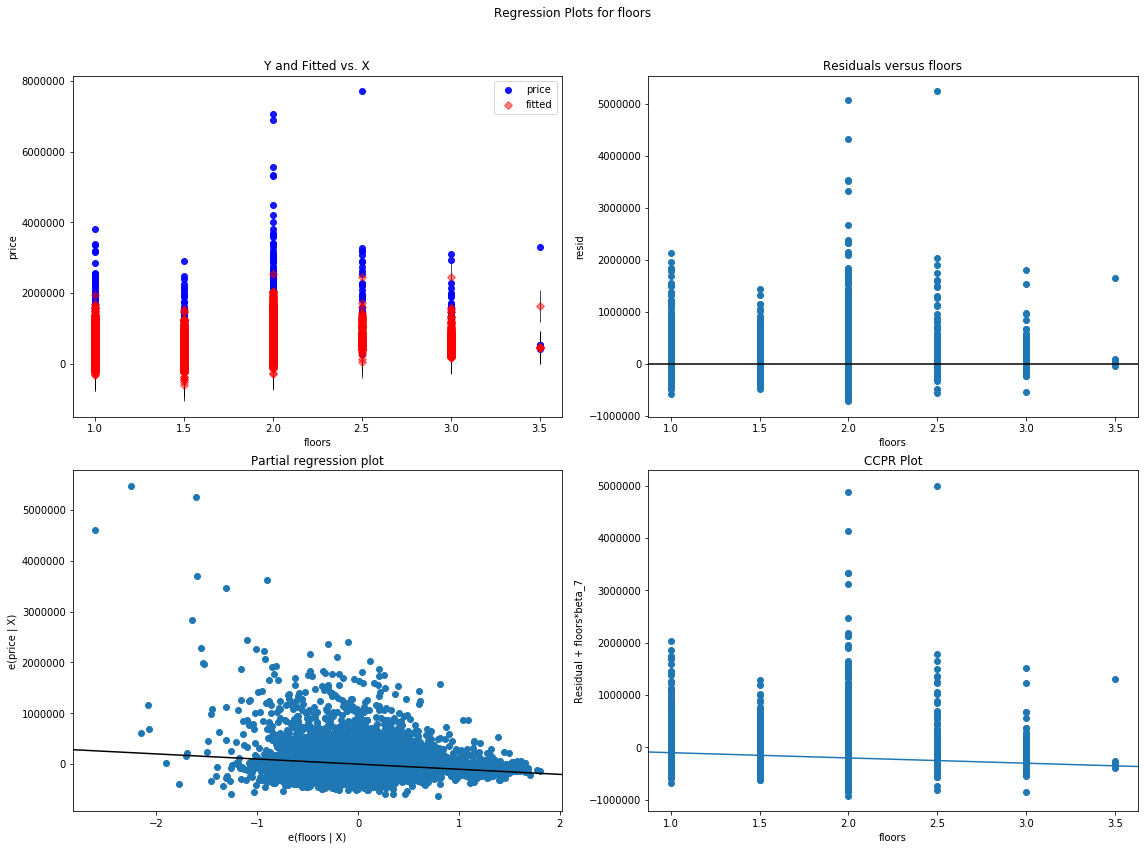

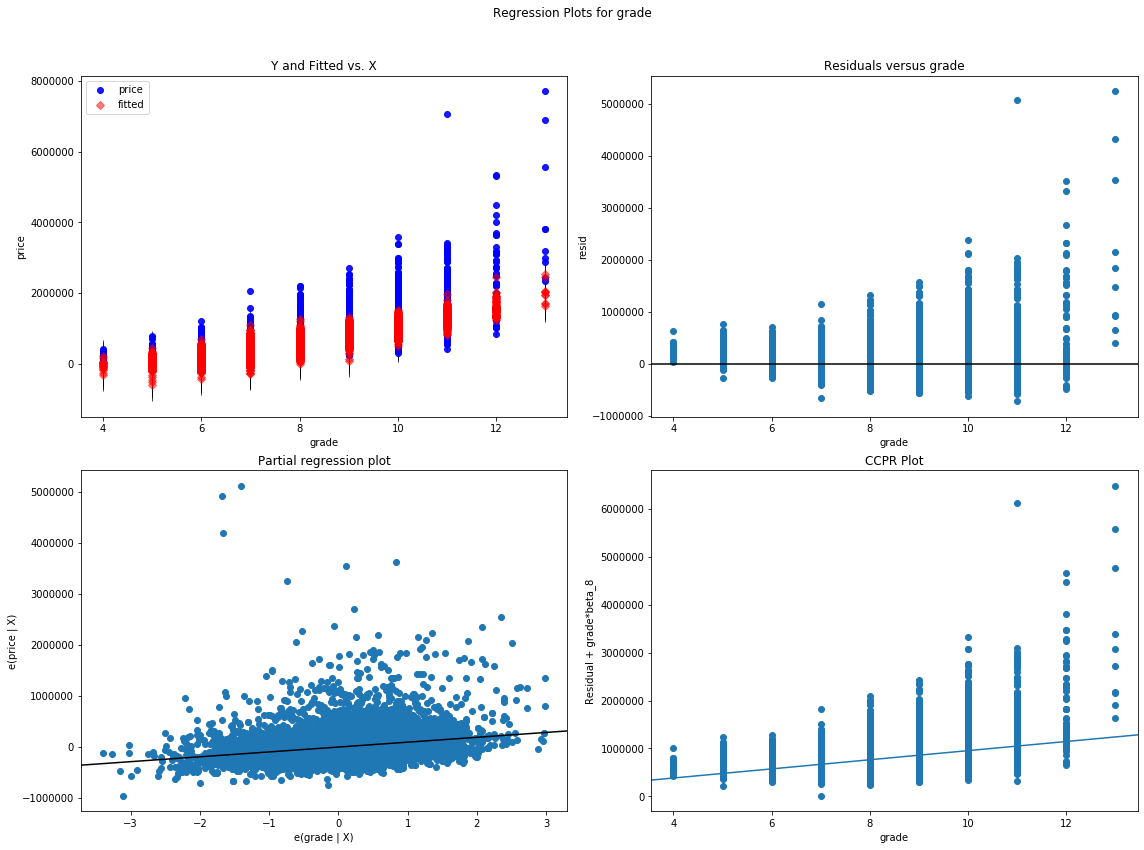

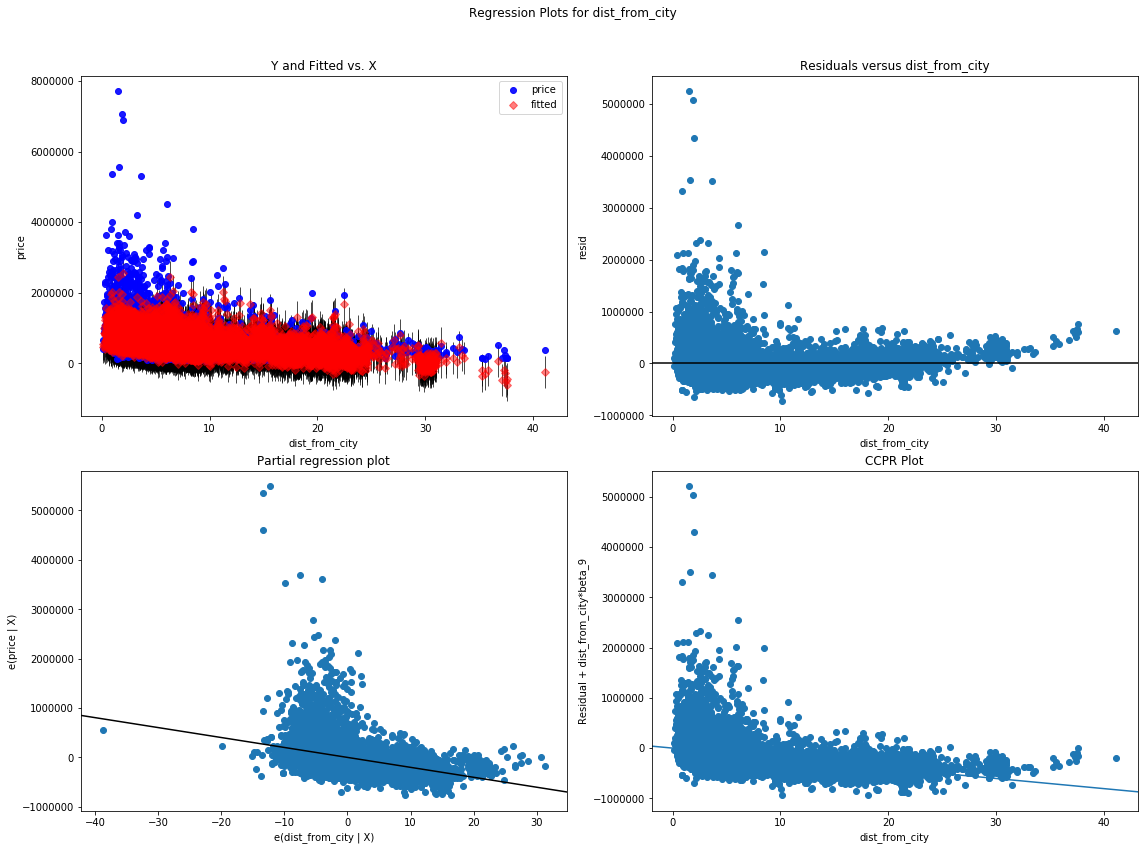

In [64]:
for col in X_train_cont_features.columns:
    fig = plt.figure(figsize=(16,12))
    sm.graphics.plot_regress_exog(model_cont_features, col, fig=fig)
    fig.show()

In [65]:
for i in range(len(X_train_cont_features.columns)):
    v=vif(np.matrix(X_train_cont_features),i)
    print("Variance inflation factor for {}: {}".format(X_train_cont_features.columns[i],round(v,2)))

Variance inflation factor for bathrooms: 20.4
Variance inflation factor for bedrooms: 19.02
Variance inflation factor for sqft_above: 17.01
Variance inflation factor for sqft_living15: 24.8
Variance inflation factor for sqft_lot: 2.36
Variance inflation factor for sqft_lot15: 2.55
Variance inflation factor for floors: 13.43
Variance inflation factor for grade: 42.31
Variance inflation factor for dist_from_city: 2.72


In [66]:
X_train_cont_features.corr()

,bathrooms,bedrooms,sqft_above,sqft_living15,sqft_lot,sqft_lot15,floors,grade,dist_from_city
bathrooms,1.000000,0.532063,0.688910,0.569046,0.100348,0.091730,0.499065,0.666160,-0.028157
bedrooms,0.532063,1.000000,0.499119,0.407847,0.037266,0.033978,0.185782,0.370765,-0.005801
sqft_above,0.688910,0.499119,1.000000,0.731819,0.200206,0.198301,0.518443,0.755877,0.023473
sqft_living15,0.569046,0.407847,0.731819,1.000000,0.147943,0.181626,0.273876,0.712445,-0.053585
sqft_lot,0.100348,0.037266,0.200206,0.147943,1.000000,0.711521,-0.002144,0.125897,0.169266
sqft_lot15,0.091730,0.033978,0.198301,0.181626,0.711521,1.000000,-0.012872,0.118662,0.184512
floors,0.499065,0.185782,0.518443,0.273876,-0.002144,-0.012872,1.000000,0.454715,-0.041096
grade,0.666160,0.370765,0.755877,0.712445,0.125897,0.118662,0.454715,1.000000,-0.133004
dist_from_city,-0.028157,-0.005801,0.023473,-0.053585,0.169266,0.184512,-0.041096,-0.133004,1.000000


### Summary

Baseline model

The residuals do not have a normal distribution, they are skewed to the right, and have heavy tails, as is shown in the q-q plot and the histogram.

From the Regression Plots we learned:

bathrooms
* correlated with target
* residuals are somewhat homoskedastic

bedrooms
* not correlated with target over all its values, only up to 5
* residuals are not homeskedastic

sqft_living
* correlated with target
* residuals are not homoskedastic.  They are close to the mean when the var is low and increase from there. **Might improve if the highest value is dropped.**

sqft_living15
* correlated with target
* residuals are somewhat homoskedastic.

sqft_lot
* not correlated with target
* residuals are not homoskedastic
* doesn't do well with small lot sizes and high prices, which would be urban settings, maybe an interaction would help

sqft_lot15
* not correlated with target
* residuals are not homoskedastic
* similar to sqft_lot

floors
* not well correlated with the target
* residuals are somewhat homoskedastic
* split levels and large 3+ floor houses cause problems.

grade
* correlated with the target
* residuals are not homoskedastic, they increase as grade increases.  May be a good candidate to be a polynomial feature

d_from_city
* negative correlation with the target, but not well for low values
* residuals are homoskedastic except for the low values

From the VIF report and the correlation report we can see that there are significant multicolinearity issues that need to be dealt with.  I will standardize the affected features and rerun the regression below.

Using a cutoff of 0.7 in the correlation matrix, the affected features are:
* bathrooms
* sqft_living
* grade
* sqft_living15

The VIF report also includes the following:
* floors
* bedrooms

Standardizing the features around 0 will maintain their interpretability while potentially dealing with the multicolinearity issues.

## Data Cleaning of Features in Simple Model

Drop the highest value from the sqft_living column

In [67]:
# index = df_clean[df_clean.sqft_living == 13540].index

# X_train = X_train.drop(index)
# y_train = y_train.drop(index)

### Standardize the features with multicolinearity issues

In [68]:
m_cols = ['bathrooms', 'sqft_above', 'sqft_living15', 'grade', 'floors', 'bedrooms']
for col in m_cols:
    scaled_col_name = col+'_scaled'
    X_train[scaled_col_name] = scale(X_train[col])

/Users/freethrall/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/freethrall/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/freethrall/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a 

In [69]:
for col in m_cols:
    scaled_col_name = col+'_scaled'
    X_test[scaled_col_name] = scale(X_test[col])

/Users/freethrall/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/freethrall/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/freethrall/anaconda3/envs/learn-env/lib/python3.6/site-packages

## Rerun simple model

The simple model was rerun with the new standardizations several times to get the best R^2, RMSE and least multicolinearity issues.

In the baseline model, sqft_lot had a high p-value, but it performed better after the above standardizations, so it was kept.

Two features still showed multicolinearity problems so they were dropped:
* sqft_living_scaled
* floors_scaled

One feature ended up with a high p-value and was dropped
* bedrooms_scaled


### Define Feature Sets

In [70]:
cont_data_cols2 = ['bathrooms_scaled', 
                   #'bedrooms_scaled', 
                   'sqft_above_scaled', 
                   'sqft_living15_scaled', 
                   'sqft_lot', 
                   #'sqft_lot15', 
                   #'floors_scaled',
                   'grade_scaled',
                  'dist_from_city']

In [71]:
X_train_cont_features_rerun = X_train[cont_data_cols2]
X_test_cont_features_rerun = X_test[cont_data_cols2]

### Linear Regression sklearn

In [72]:
lin_reg_sklearn(X_train_cont_features_rerun, X_test_cont_features_rerun, y_train, y_test)

Training Set RMSE: 233816.82421448457
Test Set RMSE: 234252.17610201385
Cross Val RMSE: 234121.0128421547


### Linear Regression statsmodels

In [73]:
model_cont_features = lin_reg_statsmodels(X_train_cont_features_rerun, y_train)

/Users/freethrall/anaconda3/envs/learn-env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.594
Model:                            OLS   Adj. R-squared:                  0.594
Method:                 Least Squares   F-statistic:                     4174.
Date:                Sat, 09 May 2020   Prob (F-statistic):               0.00
Time:                        20:24:06   Log-Likelihood:            -2.3613e+05
No. Observations:               17134   AIC:                         4.723e+05
Df Residuals:                   17127   BIC:                         4.723e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 7.068e+05   3052.020    231.576      0.000    7.01e+05    7.13e+05
bathrooms_scaled        3.1e+04   2593.069     11.955      0.000    2.59e+04    3.61e+04
sqft_above_scaled     8.311e+04   3269.076     25.424      0.000    7.67e+04    8.95e+04
sqft_living15_scaled   5.08e+04   2808.939     18.085      0.000    4.53e+04    5.63e+04
sqft_lot                 0.4468      0.047      9.531      0.000       0.355       0.539
grade_scaled          1.052e+05   3107.988     33.845      0.000    9.91e+04    1.11e+05
dist_from_city       -1.991e+04    286.785    -69.427      0.000   -2.05e+04   -1.93e+04
==============================================================================
Omnibus:                    18120.708   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          3158220.917
Skew:                           4.994   Prob(JB):                         0.00
Kurtosis:                      68.757   Cond. No.                     9.16e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.16e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Check for Multicolinearity

In [74]:
for i in range(len(X_train_cont_features_rerun.columns)):
    v=vif(np.matrix(X_train_cont_features_rerun),i)
    print("Variance inflation factor for {}: {}".format(X_train_cont_features_rerun.columns[i],round(v,2)))

Variance inflation factor for bathrooms_scaled: 2.11
Variance inflation factor for sqft_above_scaled: 3.28
Variance inflation factor for sqft_living15_scaled: 2.47
Variance inflation factor for sqft_lot: 1.22
Variance inflation factor for grade_scaled: 2.95
Variance inflation factor for dist_from_city: 1.2


In [75]:
X_train_cont_features_rerun.corr()

,bathrooms_scaled,sqft_above_scaled,sqft_living15_scaled,sqft_lot,grade_scaled,dist_from_city
bathrooms_scaled,1.000000,0.688910,0.569046,0.100348,0.666160,-0.028157
sqft_above_scaled,0.688910,1.000000,0.731819,0.200206,0.755877,0.023473
sqft_living15_scaled,0.569046,0.731819,1.000000,0.147943,0.712445,-0.053585
sqft_lot,0.100348,0.200206,0.147943,1.000000,0.125897,0.169266
grade_scaled,0.666160,0.755877,0.712445,0.125897,1.000000,-0.133004
dist_from_city,-0.028157,0.023473,-0.053585,0.169266,-0.133004,1.000000


### Regression Plots

/Users/freethrall/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


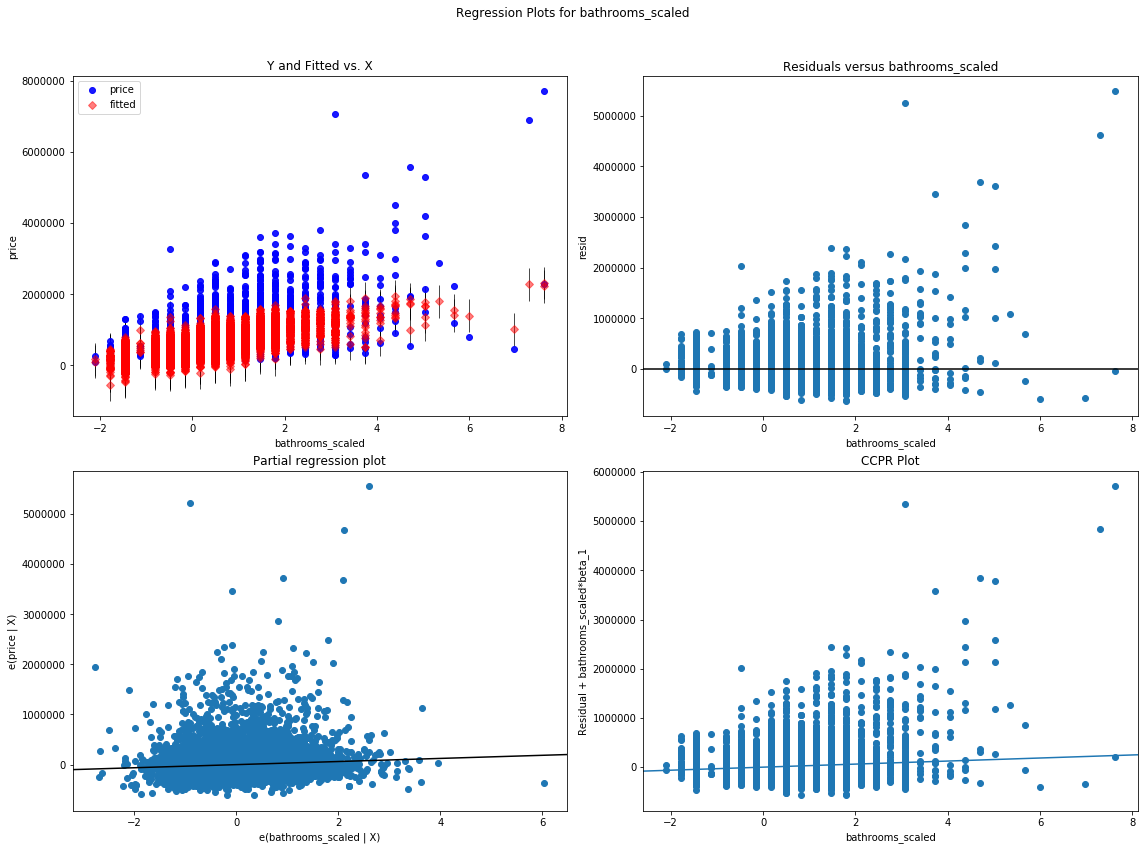

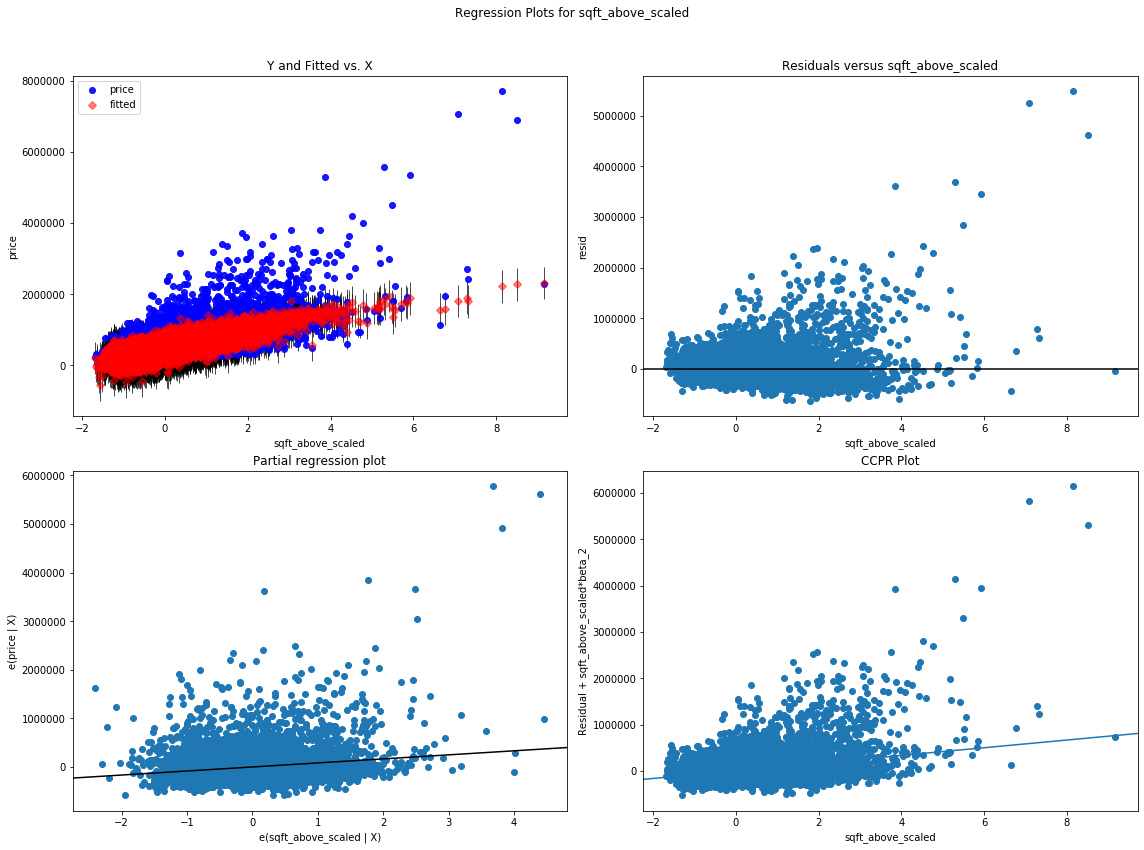

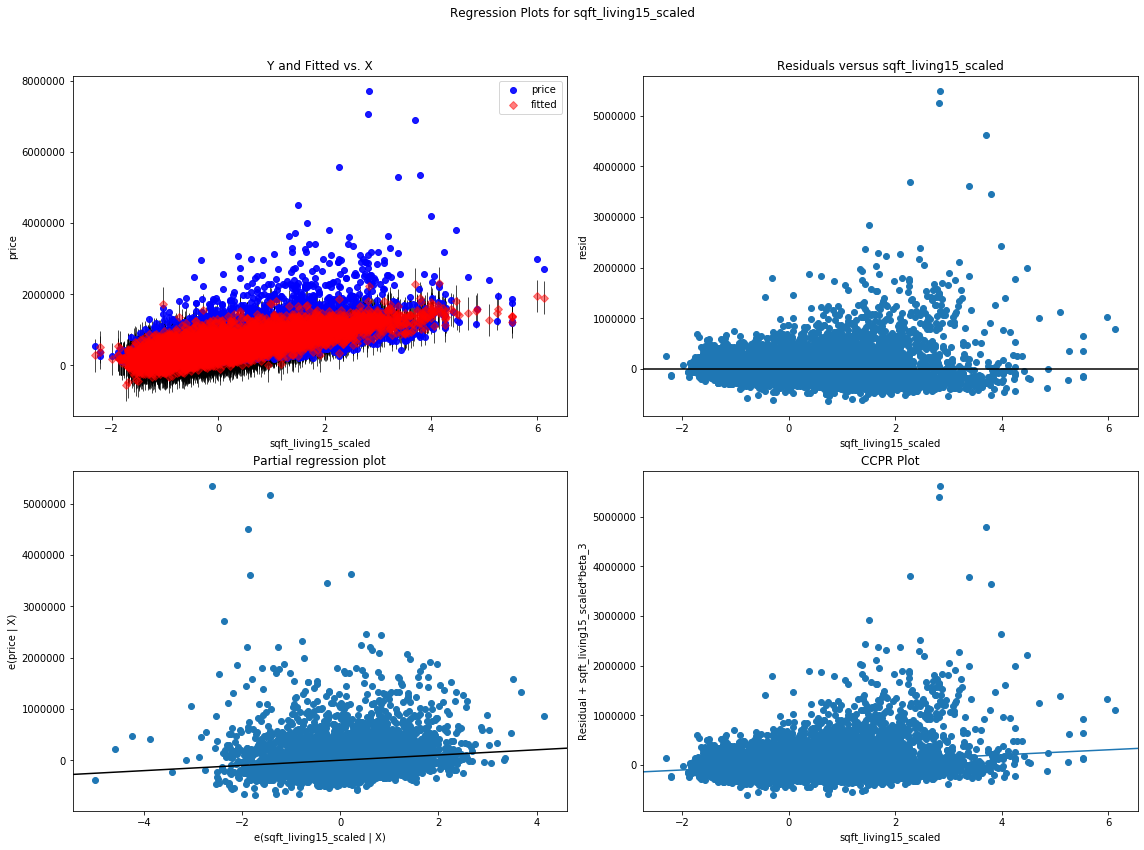

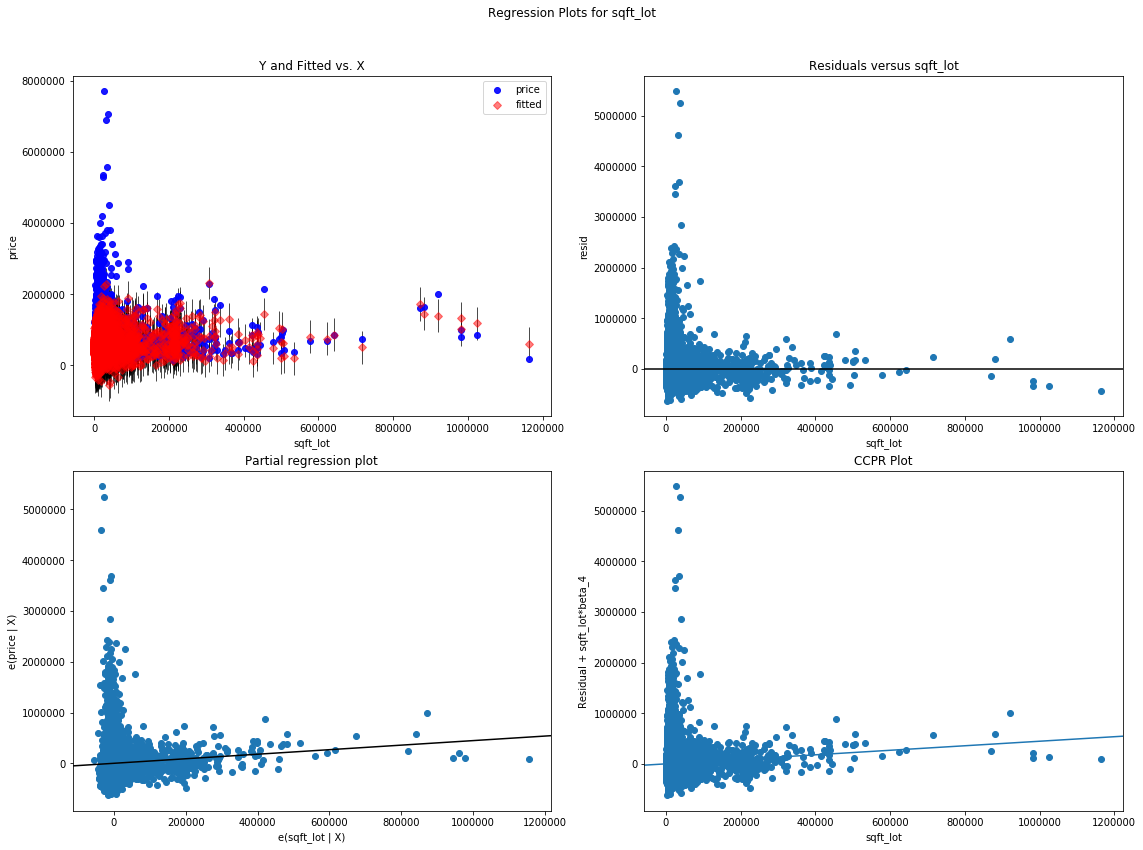

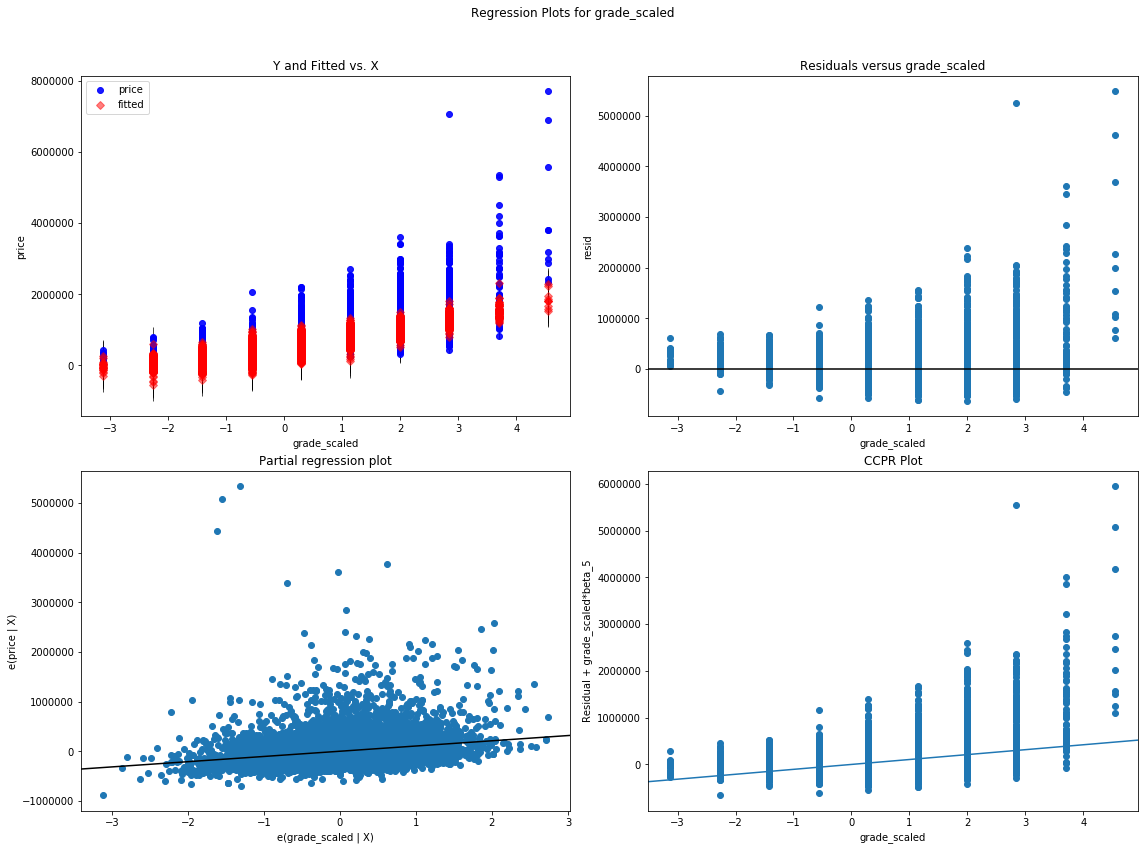

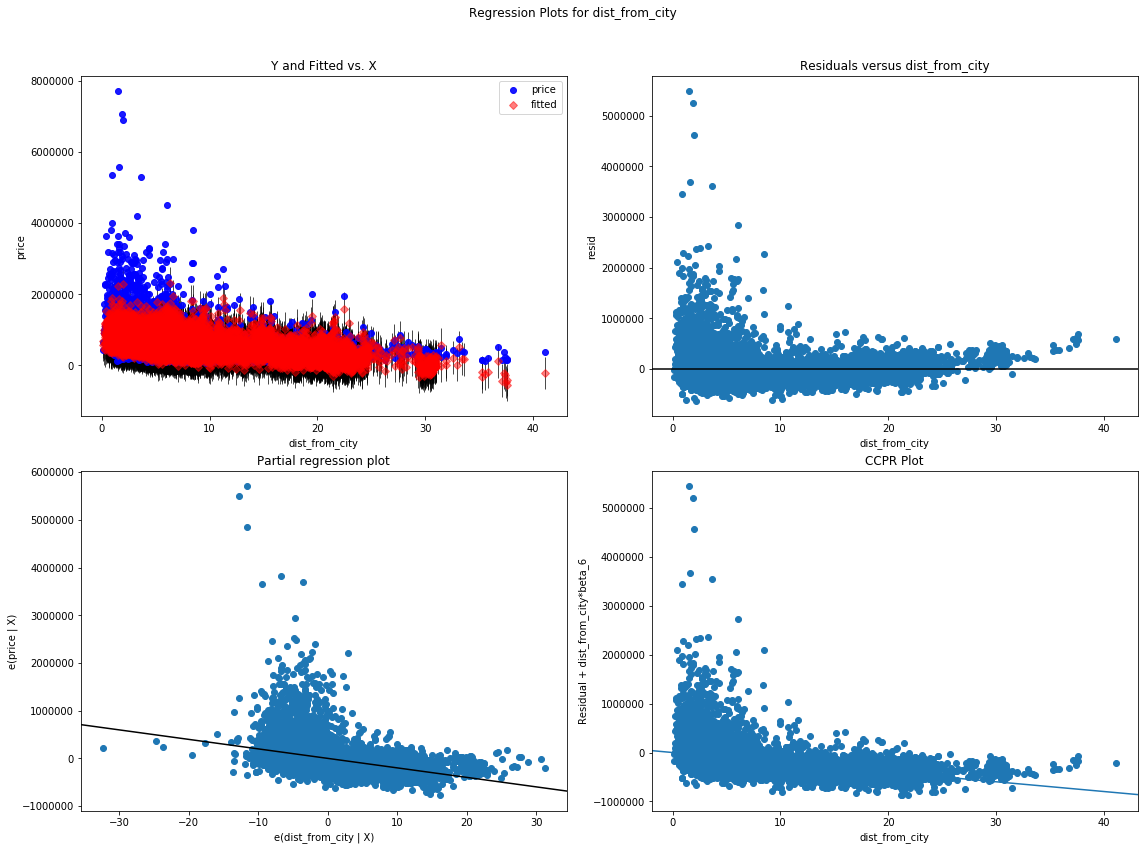

In [76]:
regression_plots(X_train_cont_features_rerun, model_cont_features)

### Summary

Removing the largest outlier in sqft_living improved the correlation of sqft_living to the target, but only had marginal improvement to the model.

The standardizations reduced the multicolinearity of the model, but not all of it.  Multiple features were removed to make the interpretation of the remaining features better, but the model's performance stats, R^2 and RMSE got worse.  Despite the worse stats, the coefficients should be more trustworthy.

## Add Features based upon findings of Simple Model

### Add Categorical Feature for Houses over 3 million dollars

In [77]:
# df_clean['mansion'] = 0

In [78]:
# mask = y_train[y_train >= 3000000].index

In [79]:
# df_clean.loc[mask, 'mansion'] = 1

In [80]:
# df_clean = make_category(df_clean, 'mansion')

### Flag for urban

5 miles or less from a city center

In [85]:
def is_urban(distance):
    """return if the distance is 5 or less from the center of a city"""
    if distance >=5:
        return 0
    else:
        return 1
        
X_train['urban'] = X_train.dist_from_city.apply(is_urban)

/Users/freethrall/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [88]:
X_test['urban'] = X_test.dist_from_city.apply(is_urban)

/Users/freethrall/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


## Simple Model + Categoricals

This model will contain all the continuous variables and the categorical variables.  The continuous variables that were removed above will be put back into the feature list for the initial run of this model.

### Define Feature Sets

Because there are no so many features, I will specify which to ignore instead of which to include.

In [86]:
for col in X_train.columns:
    print(col)

id
date
bedrooms
bathrooms
sqft_living
sqft_lot
floors
grade
sqft_above
sqft_basement
yr_built
yr_renovated
lat
long
sqft_living15
sqft_lot15
view__1
view__2
view__3
view__4
waterfront__1
had_reno__1
yr_updated_(1954.0, 1977.0]
yr_updated_(1977.0, 1999.0]
yr_updated_(1999.0, 2015.0]
condition_2
condition_3
condition_4
condition_5
_98002
_98003
_98004
_98005
_98006
_98007
_98008
_98010
_98011
_98014
_98019
_98022
_98023
_98024
_98027
_98028
_98029
_98030
_98031
_98032
_98033
_98034
_98038
_98039
_98040
_98042
_98045
_98052
_98053
_98055
_98056
_98058
_98059
_98065
_98070
_98072
_98074
_98075
_98077
_98092
_98102
_98103
_98105
_98106
_98107
_98108
_98109
_98112
_98115
_98116
_98117
_98118
_98119
_98122
_98125
_98126
_98133
_98136
_98144
_98146
_98148
_98155
_98166
_98168
_98177
_98178
_98188
_98198
_98199
season__1
season__2
split_level__1
has_basement__1
dist_from_city
bathrooms_scaled
sqft_above_scaled
sqft_living15_scaled
grade_scaled
floors_scaled
bedrooms_scaled
urban


In [89]:
cols_to_ignore = ['id', 'date', 'zipcode', 'lat', 'long', 
                  'yr_built', 'yr_renovated', 'sqft_above',
                 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_living15', 
                  'floors', 'grade', 'sqft_basement']
ssc_cols = [col for col in X_train.columns if col not in cols_to_ignore]

# sort the column names for easier interpretation
ssc_cols = sorted(ssc_cols)

X_train_ssc_features = X_train[ssc_cols]
X_test_ssc_features = X_test[ssc_cols]

### Linear Regression sklearn

In [90]:
lin_reg_sklearn(X_train_ssc_features, X_test_ssc_features, y_train, y_test)

Training Set RMSE: 163151.3421421947
Test Set RMSE: 162689.244582288
Cross Val RMSE: 165323.8526521475


### Linear Regression Statsmodels

In [91]:
model_ssc_features = lin_reg_statsmodels(X_train_ssc_features, y_train)

/Users/freethrall/anaconda3/envs/learn-env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.802
Model:                            OLS   Adj. R-squared:                  0.801
Method:                 Least Squares   F-statistic:                     720.0
Date:                Sat, 09 May 2020   Prob (F-statistic):               0.00
Time:                        20:35:43   Log-Likelihood:            -2.2996e+05
No. Observations:               17134   AIC:                         4.601e+05
Df Residuals:                   17037   BIC:                         4.609e+05
Df Model:                          96                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                        4.627e+05   4.32e+04     10.720      0.000    3.78e+05    5.47e+05
_98002                       2.536e+04   1.62e+04      1.567      0.117   -6354.803    5.71e+04
_98003                      -1.516e+04   1.47e+04     -1.032      0.302    -4.4e+04    1.36e+04
_98004                       6.198e+05   2.36e+04     26.294      0.000    5.74e+05    6.66e+05
_98005                       1.329e+05   2.47e+04      5.389      0.000    8.46e+04    1.81e+05
_98006                        1.41e+05   2.01e+04      7.032      0.000    1.02e+05     1.8e+05
_98007                       9.919e+04   2.55e+04      3.895      0.000    4.93e+04    1.49e+05
_98008                       1.015e+05    2.2e+04      4.606      0.000    5.83e+04    1.45e+05
_98010                       6.559e+04   2.11e+04      3.106      0.002    2.42e+04    1.07e+05
_98011                      -1.022e+04   2.23e+04     -0.458      0.647    -5.4e+04    3.35e+04
_98014                       4.046e+04    2.1e+04      1.924      0.054    -763.891    8.17e+04
_98019                      -1.388e+04   2.05e+04     -0.677      0.498   -5.41e+04    2.63e+04
_98022                       4.321e+04   1.78e+04      2.429      0.015    8336.708    7.81e+04
_98023                      -2.324e+04   1.27e+04     -1.826      0.068   -4.82e+04    1712.264
_98024                       9.063e+04   2.53e+04      3.579      0.000     4.1e+04     1.4e+05
_98027                       8.316e+04   1.73e+04      4.803      0.000    4.92e+04    1.17e+05
_98028                      -7285.8926   2.08e+04     -0.351      0.726    -4.8e+04    3.34e+04
_98029                       1.199e+05   1.83e+04      6.564      0.000    8.41e+04    1.56e+05
_98030                      -2.948e+04   1.52e+04     -1.937      0.053   -5.93e+04     350.394
_98031                      -3.577e+04   1.61e+04     -2.226      0.026   -6.73e+04   -4272.393
_98032                      -1.769e+04   1.95e+04     -0.907      0.364   -5.59e+04    2.05e+04
_98033                       1.878e+05   2.28e+04      8.241      0.000    1.43e+05    2.32e+05
_98034                       5.053e+04    2.1e+04      2.405      0.016    9353.064    9.17e+04
_98038                       1.044e+04   1.25e+04      0.835      0.404   -1.41e+04    3.49e+04
_98039                       1.255e+06   3.37e+04     37.293      0.000    1.19e+06    1.32e+06
_98040                       3.681e+05   2.19e+04     16.789      0.000    3.25e+05    4.11e+05
_98042                      -2.533e+04   1.29e+04     -1.970      0.049   -5.05e+04    -129.464
_98045                       9.417e+04   1.58e+04      5.943      0.000    6.31e+04    1.25e+05
_98052                       6.118e+04    2.2e+04      2.784      0.005    1.81e+04    1.04e+05
_98053     

### Check for Multicolinearity

In [ ]:
vif_analysis(X_train_ssc_features)

### Analyze the Residuals

In [ ]:
sm.graphics.qqplot(model_ssc_features.resid, line='45', fit=True);

### Stepwise Selection

Remove the columns with multicolinearity issues before running stepwise selection.

The yr_updated features don't make sense, a base value of the oldest houses shouldn't be the most expensive house, so they also will be removed.

In [ ]:
# columns with multicolinearity issues
m_cols = ['floors_scaled', 'bedrooms_scaled', 'yr_updated_(1954.0, 1977.0]',
         'yr_updated_(1977.0, 1999.0]', 'yr_updated_(1999.0, 2015.0]']

X_train_cols = [col for col in X_train_ssc_features.columns if col not in m_cols]

In [ ]:
BidirectionalStepwiseSelection(X_train_ssc_features[X_train_cols], y_train, elimination_criteria='aic')

### Summary

The R^2 and RMSE stats saw a significant improvement over the baseline model.

Some of the features that were dropped from the baseline model were found to be significant here.

There still seemed to be some multicolinearity issues with floors_scaled and bedrooms_scaled.

There were quite a few of the categorical features that had high p-values.  A stepwise selection was run to find out a potentially better feature set.

## Rerun the Simple + Categoricals Model

The simple + categoricals model will be rerun with the feature set chosen by stepwise selection.

### Define Features

In [ ]:
# columns chosen by stepwise selection
cols_to_include = ['sqft_living_scaled', 'dist_from_city', 'waterfront__1', '_98004', '_98039', 'grade_scaled', '_98112', 'view__4', '_98040', 'view__3', '_98105', 'condition_3', 'yr_updated_(1954.0, 1977.0]', 'yr_updated_(1977.0, 1999.0]', 'yr_updated_(1999.0, 2015.0]', 'had_reno__1', '_98119', '_98033', 'view__2', '_98102', '_98178', '_98103', '_98199', '_98117', '_98115', '_98109', 'has_basement', '_98107', 'sqft_lot', '_98006', '_98122', '_98045', '_98022', 'view__1', '_98029', 'condition_5', '_98177', '_98116', '_98058', '_98144', '_98005', 'season__1', '_98008', '_98136', '_98027', '_98010', '_98168', '_98056', '_98059', '_98070', '_98198', '_98146', '_98108', '_98028', '_98055', '_98106', '_98188', '_98031', '_98166', '_98019', '_98011', '_98024', '_98042', '_98030', '_98077', '_98155', '_98118', '_98032', '_98092', '_98023', '_98007', '_98148', '_98003']


In [ ]:
# sort the column names for easier interpretation
cols_to_include = sorted(cols_to_include)

In [ ]:
X_train_ssc_features_rerun = X_train[cols_to_include]
X_test_ssc_features_rerun = X_test[cols_to_include]

### Linear Regression sklearn

In [ ]:
lin_reg_sklearn(X_train_ssc_features_rerun, X_test_ssc_features_rerun, y_train, y_test)

### Linear Regression Statsmodels

In [ ]:
model_ssc_features = lin_reg_statsmodels(X_train_ssc_features_rerun, y_train)

### Check for Multicolinearity

In [ ]:
vif_analysis(X_train_ssc_features_rerun)

### Analyze the Residuals

In [ ]:
sm.graphics.qqplot(model_ssc_features.resid, line='45', fit=True);

### Summary

The re-run of the simple plus categoricals model did not change the R^2 and RMSE much, they in fact got a little worse, which is often the case when features are dropped, even if they are not significant.

However, the re-run with its feature set is the best model so far.

## Add Interaction Features

### sq_lot / sq_lot15

The size of the house lot as compared to its neighbors

In [92]:
X_train['lot*lot15'] = X_train.sqft_lot * X_train.sqft_lot15
X_test['lot*lot15'] = X_test.sqft_lot * X_test.sqft_lot15

/Users/freethrall/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/freethrall/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


### bathroom* bedroom

Home buyers often want enough bathrooms for the bedrooms in a house.

In [93]:
X_train['bathrooms_scaled*bedrooms_scaled'] = X_train.bathrooms_scaled * X_train.bedrooms_scaled
X_test['bathrooms_scaled*bedrooms_scaled'] = X_test.bathrooms_scaled * X_test.bedrooms_scaled

/Users/freethrall/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/freethrall/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


### sqft_living * floors

How the living space is split up among the floors

In [95]:
X_train['sqft_above_scaled*floors_scaled'] = X_train.sqft_above_scaled * X_train.floors_scaled
X_test['sqft_above_scaled*floors_scaled'] = X_test.sqft_above_scaled * X_test.floors_scaled

/Users/freethrall/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/freethrall/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


### sqft_living * sqft_living15

How the living space compares to its neighbors

In [96]:
X_train['sqft_above_scaled*sqft_living15_scaled'] = X_train.sqft_above_scaled * X_train.sqft_living15_scaled
X_test['sqft_above_scaled*sqft_living15_scaled'] = X_test.sqft_above_scaled * X_test.sqft_living15_scaled

/Users/freethrall/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/freethrall/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


### sqft_living * sqft_lot

How the house fits on the property

In [97]:
X_train['sqft_above_scaled*sqft_lot'] = X_train.sqft_above_scaled * X_train.sqft_lot
X_test['sqft_above_scaled*sqft_lot'] = X_test.sqft_above_scaled * X_test.sqft_lot

/Users/freethrall/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/freethrall/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


### sqft_living * bedrooms

How big are the bedrooms?

In [98]:
X_train['sqft_above_scaled*bedrooms_scaled'] = X_train.sqft_above_scaled * X_train.bedrooms_scaled
X_test['sqft_above_scaled*bedrooms_scaled'] = X_test.sqft_above_scaled * X_test.bedrooms_scaled

/Users/freethrall/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/freethrall/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


### season_1*waterfront_1

In [99]:
X_train['season__1*waterfront__1'] = X_train.season__1 * X_train.waterfront__1
X_test['season__1*waterfront__1'] = X_test.season__1 * X_test.waterfront__1

/Users/freethrall/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/freethrall/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


### floors*split_level__1

In [100]:
X_train['floors_scaled*split_level__1'] = X_train.floors_scaled * X_train.split_level__1
X_test['floors_scaled*split_level__1'] = X_test.floors_scaled * X_test.split_level__1

/Users/freethrall/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/freethrall/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


### had_reno*year_updated Bins

In [101]:
year_bins = ['yr_updated_(1977.0, 1999.0]', 'yr_updated_(1954.0, 1977.0]', 'yr_updated_(1999.0, 2015.0]']
for year in year_bins:
    col_name = 'had_reno*'+year
    X_train[col_name] = X_train.had_reno__1 * X_train[year]
    X_test[col_name] = X_test.had_reno__1 * X_test[year]

/Users/freethrall/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/freethrall/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


### is_urban*dist_from_city

In [104]:
# X_train['urban*dist_from_city'] = X_train.urban * X_train.dist_from_city
# X_test['urban*dist_from_city'] = X_test.urban * X_test.dist_from_city

/Users/freethrall/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/freethrall/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


## Model With Interactions

This model will run with all the continuous and categorical features, plus the new interaction features.

### Define Feature Sets

In [105]:
cols_to_ignore = ['id', 'date', 'zipcode', 'lat', 'long', 
                  'yr_built', 'yr_renovated', 'sqft_above',
                 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_living15', 
                  'floors', 'grade', 'sqft_basement']
int_cols = [col for col in X_train.columns if col not in cols_to_ignore]

# sort the column names for easier interpretation
int_cols = sorted(int_cols)

X_train_int_features = X_train[int_cols]
X_test_int_features = X_test[int_cols]

### Linear Regression sklearn

In [106]:
lin_reg_sklearn(X_train_int_features, X_test_int_features, y_train, y_test)

Training Set RMSE: 157236.07906348153
Test Set RMSE: 159792.16490907152
Cross Val RMSE: 160795.79503098718


### Linear Regression statsmodels

In [107]:
model_int_features = lin_reg_statsmodels(X_train_int_features, y_train)

/Users/freethrall/anaconda3/envs/learn-env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.816
Model:                            OLS   Adj. R-squared:                  0.815
Method:                 Least Squares   F-statistic:                     700.7
Date:                Sat, 09 May 2020   Prob (F-statistic):               0.00
Time:                        20:40:59   Log-Likelihood:            -2.2933e+05
No. Observations:               17134   AIC:                         4.589e+05
Df Residuals:                   17025   BIC:                         4.597e+05
Df Model:                         108                                         
Covariance Type:            nonrobust                                         
==========================================================================================================
                                             coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
const                                   3.908e+05   4.22e+04      9.270      0.000    3.08e+05    4.73e+05
_98002                                  1.441e+04   1.56e+04      0.923      0.356   -1.62e+04     4.5e+04
_98003                                 -1.791e+04   1.42e+04     -1.263      0.206   -4.57e+04    9877.901
_98004                                   5.87e+05   2.34e+04     25.112      0.000    5.41e+05    6.33e+05
_98005                                  1.249e+05   2.39e+04      5.222      0.000     7.8e+04    1.72e+05
_98006                                  1.487e+05   1.99e+04      7.482      0.000     1.1e+05    1.88e+05
_98007                                  8.857e+04   2.46e+04      3.606      0.000    4.04e+04    1.37e+05
_98008                                  1.114e+05   2.14e+04      5.202      0.000    6.94e+04    1.53e+05
_98010                                  6.312e+04   2.04e+04      3.096      0.002    2.32e+04    1.03e+05
_98011                                  1.736e+04    2.2e+04      0.790      0.429   -2.57e+04    6.04e+04
_98014                                  4.384e+04   2.04e+04      2.148      0.032    3828.240    8.39e+04
_98019                                  8309.6250   2.01e+04      0.414      0.679    -3.1e+04    4.76e+04
_98022                                   2.41e+04   1.73e+04      1.390      0.165   -9889.532    5.81e+04
_98023                                 -2.755e+04   1.23e+04     -2.244      0.025   -5.16e+04   -3481.353
_98024                                  9.974e+04   2.46e+04      4.054      0.000    5.15e+04    1.48e+05
_98027                                  9.873e+04    1.7e+04      5.809      0.000    6.54e+04    1.32e+05
_98028                                   2.79e+04   2.06e+04      1.358      0.175   -1.24e+04    6.82e+04
_98029                                  1.398e+05   1.79e+04      7.805      0.000    1.05e+05    1.75e+05
_98030                                 -2.012e+04   1.47e+04     -1.368      0.171    -4.9e+04    8717.102
_98031                                  -2.93e+04   1.56e+04     -1.879      0.060   -5.99e+04    1265.844
_98032                                 -2.492e+04   1.88e+04     -1.323      0.186   -6.19e+04     1.2e+04
_98033                                  1.573e+05   2.25e+04      6.988      0.000    1.13e+05    2.01e+05
_98034                                   4.57e+04   2.03e+04      2.251      0.024    5913.200    8.55e+04
_98038                                  1.989e+04   1.21e+04      1.647      0.100   -3776.789    4.35e+04
_98039                                  1.182e+06   3.28e+04     36.029      0.000    1.12e+06    1.25e+06
_98040                                  3.708e+05   2.13e+04     17.386      0.000    3

### Check for Multicolinearity

In [ ]:
vif_analysis(X_train_int_features)

### Analyze the Residuals

In [ ]:
sm.graphics.qqplot(model_int_features.resid, line='45', fit=True);

### Stepwise Selection

In [ ]:
BidirectionalStepwiseSelection(X_train_int_features, y_train, elimination_criteria='aic')

## Re-Run Model with Interactions

### Define Features

In [ ]:
# columns chosen by stepwise selection
cols_to_include = ['sqft_living_scaled*sqft_living15_scaled', 'sqft_living_scaled', '_98004', 'grade_scaled', 'waterfront__1', '_98039', '_98112', '_98040', 'view__4', '_98105', '_98033', '_98119', '_98199', '_98115', '_98103', '_98117', '_98109', '_98102', '_98122', '_98107', 'sqft_living_scaled*floors_scaled', '_98023', 'view__3', '_98144', '_98116', '_98042', '_98092', '_98006', '_98052', '_98005', '_98136', '_98008', '_98034', '_98177', '_98125', 'had_reno*yr_updated_(1999.0, 2015.0]', '_98029', '_98053', 'view__2', 'condition_5', '_98007', '_98126', '_98118', '_98133', '_98074', 'sqft_lot', '_98027', 'view__1', '_98075', '_98072', '_98155', '_98028', 'season__1', '_98106', 'sqft_living_scaled*sqft_lot', 'split_level__1', '_98011', 'bedrooms_scaled', '_98056', '_98108', '_98022', '_98003', '_98198', '_98024', '_98077', 'has_basement', 'floors_scaled*split_level__1', '_98146', '_98059', 'yr_updated_(1954.0, 1977.0]', '_98166', 'lot*lot15', '_98045', 'sqft_lot15', '_98019', 'season__1*waterfront__1', '_98014', '_98065', 'had_reno*yr_updated_(1977.0, 1999.0]', 'condition_4', '_98168', '_98055', '_98038', 'bathrooms_scaled*bedrooms_scaled', 'floors_scaled']
# columns to add back because of interactions that are significant
cols_to_add = ['sqft_living15_scaled', 'yr_updated_(1977.0, 1999.0]', 'yr_updated_(1999.0, 2015.0]']
# combine the lists
cols_to_include = cols_to_include + cols_to_add

In [ ]:
# sort the column names for easier interpretation
cols_to_include = sorted(cols_to_include)

In [ ]:
X_train_int_features_rerun = X_train[cols_to_include]
X_test_int_features_rerun = X_test[cols_to_include]

### Linear Regression sklearn

In [ ]:
lin_reg_sklearn(X_train_int_features_rerun, X_test_int_features_rerun, y_train, y_test)

### Linear Regression statsmodels

In [ ]:
model_int_features = lin_reg_statsmodels(X_train_int_features_rerun, y_train)

### Summary

There are improvements to R^2 and RMSE with the addition of interating features, but the model is getting complicated.

## Model with Polynomials

This model will have all the continuous, categorical, and interacting features, plus polynomial ones

### Define Feature Sets

In [108]:
cols_to_ignore = ['id', 'date', 'zipcode', 'lat', 'long', 
                  'yr_built', 'yr_renovated', 'sqft_above',
                 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_living15', 
                  'floors', 'grade', 'sqft_basement']
poly_cols = [col for col in X_train.columns if col not in cols_to_ignore]

# sort the column names for easier interpretation
poly_cols = sorted(poly_cols)
X_train_poly_features = X_train[poly_cols]
X_test_poly_features = X_test[poly_cols]

### Add polynomials

In [109]:
poly = PolynomialFeatures(3)
poly_grade_train = poly.fit_transform(X_train_poly_features['grade_scaled'].values.reshape(-1, 1))
poly_grade_test = poly.fit_transform(X_test_poly_features['grade_scaled'].values.reshape(-1, 1))

In [110]:
X_train_poly_features['grade^2'] = poly_grade_train[:, 2]
X_test_poly_features['grade^2'] = poly_grade_test[:, 2]
X_train_poly_features['grade^3'] = poly_grade_train[:, 3]
X_test_poly_features['grade^3'] = poly_grade_test[:, 3]

/Users/freethrall/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/freethrall/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/freethrall/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

### Linear Regression sklearn

In [111]:
lin_reg_sklearn(X_train_poly_features, X_test_poly_features, y_train, y_test)

Training Set RMSE: 149551.24219781702
Test Set RMSE: 155980.5637895808
Cross Val RMSE: 152674.66131667985


### Linear Regression statsmodels

In [112]:
model_poly_features = lin_reg_statsmodels(X_train_poly_features, y_train)

/Users/freethrall/anaconda3/envs/learn-env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.834
Model:                            OLS   Adj. R-squared:                  0.833
Method:                 Least Squares   F-statistic:                     776.7
Date:                Sat, 09 May 2020   Prob (F-statistic):               0.00
Time:                        20:42:25   Log-Likelihood:            -2.2847e+05
No. Observations:               17134   AIC:                         4.572e+05
Df Residuals:                   17023   BIC:                         4.580e+05
Df Model:                         110                                         
Covariance Type:            nonrobust                                         
==========================================================================================================
                                             coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
const                                   3.322e+05   4.02e+04      8.260      0.000    2.53e+05    4.11e+05
_98002                                  1565.3430   1.49e+04      0.105      0.916   -2.76e+04    3.07e+04
_98003                                 -9056.0645   1.35e+04     -0.672      0.502   -3.55e+04    1.74e+04
_98004                                  5.679e+05   2.22e+04     25.526      0.000    5.24e+05    6.11e+05
_98005                                  1.288e+05   2.28e+04      5.659      0.000    8.42e+04    1.73e+05
_98006                                  1.354e+05   1.89e+04      7.161      0.000    9.84e+04    1.73e+05
_98007                                  9.476e+04   2.34e+04      4.054      0.000    4.89e+04    1.41e+05
_98008                                  1.128e+05   2.04e+04      5.538      0.000    7.29e+04    1.53e+05
_98010                                  6.144e+04   1.94e+04      3.165      0.002    2.34e+04    9.95e+04
_98011                                  2.467e+04   2.09e+04      1.181      0.238   -1.63e+04    6.56e+04
_98014                                  4.526e+04   1.94e+04      2.328      0.020    7152.366    8.34e+04
_98019                                  5478.3727   1.91e+04      0.287      0.774   -3.19e+04    4.29e+04
_98022                                  3.089e+04   1.65e+04      1.872      0.061   -1447.026    6.32e+04
_98023                                 -2.059e+04   1.17e+04     -1.763      0.078   -4.35e+04    2304.565
_98024                                  1.099e+05   2.34e+04      4.695      0.000     6.4e+04    1.56e+05
_98027                                  9.333e+04   1.62e+04      5.769      0.000    6.16e+04    1.25e+05
_98028                                   2.76e+04   1.95e+04      1.412      0.158   -1.07e+04    6.59e+04
_98029                                  1.505e+05    1.7e+04      8.833      0.000    1.17e+05    1.84e+05
_98030                                 -2.103e+04    1.4e+04     -1.503      0.133   -4.85e+04    6402.866
_98031                                 -2.839e+04   1.48e+04     -1.914      0.056   -5.75e+04     687.616
_98032                                   -2.1e+04   1.79e+04     -1.172      0.241   -5.61e+04    1.41e+04
_98033                                  1.525e+05   2.14e+04      7.119      0.000     1.1e+05    1.94e+05
_98034                                  4.238e+04   1.93e+04      2.195      0.028    4528.957    8.02e+04
_98038                                  1.926e+04   1.15e+04      1.677      0.094   -3250.821    4.18e+04
_98039                                  1.111e+06   3.13e+04     35.533      0.000    1.05e+06    1.17e+06
_98040                                  3.611e+05   2.03e+04     17.784      0.000    3

### Check for Multicolinearity

In [ ]:
vif_analysis(X_train_poly_features)

### Residuals

In [ ]:
p=plt.scatter(x=model_poly_features.fittedvalues,y=model_poly_features.resid,edgecolor='k')
xmin=min(model_poly_features.fittedvalues)
xmax = max(model_poly_features.fittedvalues)
plt.hlines(y=0,xmin=xmin*0.9,xmax=xmax*1.1,color='red',linestyle='--',lw=3)
plt.xlabel("Fitted values",fontsize=15)
plt.ylabel("Residuals",fontsize=15)
plt.title("Fitted vs. residuals plot",fontsize=18)
plt.grid(True)
plt.show()

### Stepwise Selection

Remove the columns with multicolinearity issues before running stepwise selection.

In [ ]:
# columns with multicolinearity issues
m_cols = []

X_train_cols = [col for col in X_train_poly_features.columns if col not in m_cols]

In [ ]:
BidirectionalStepwiseSelection(X_train_poly_features[X_train_cols], y_train, elimination_criteria='aic')

## Re-Run Polynomial Model

### Define Features

In [ ]:
# columns chosen by stepwise selection
cols_to_include = ['grade^3', '_98004', 'sqft_living_scaled', 'waterfront__1', '_98039', '_98112', '_98040', 'view__4', '_98105', '_98119', '_98199', '_98033', '_98103', '_98115', 'sqft_living_scaled*sqft_living15_scaled', '_98117', '_98109', '_98102', '_98122', '_98107', '_98023', 'grade_scaled', 'grade^2', 'view__3', '_98116', '_98144', '_98052', '_98092', 'sqft_living_scaled*floors_scaled', '_98006', '_98005', '_98008', '_98136', '_98034', '_98177', '_98125', '_98053', '_98029', 'had_reno*yr_updated_(1999.0, 2015.0]', 'view__2', 'condition_5', '_98007', '_98074', '_98126', 'view__1', '_98133', '_98027', '_98118', '_98072', '_98075', '_98155', 'sqft_lot', 'sqft_living_scaled*sqft_lot', '_98028', 'season__1', '_98011', '_98106', '_98056', '_98108', 'has_basement', '_98077', '_98024', '_98059', '_98146', '_98065', '_98045', '_98019', '_98166', '_98014', 'season__1*waterfront__1', 'had_reno*yr_updated_(1977.0, 1999.0]', 'split_level__1', 'bedrooms_scaled', 'lot*lot15', '_98022', 'condition_4', 'sqft_lot15', 'floors_scaled*split_level__1', 'yr_updated_(1999.0, 2015.0]', 'yr_updated_(1954.0, 1977.0]', 'floors_scaled', '_98055', '_98038', '_98168', '_98058', '_98010', '_98148', '_98178', 'had_reno*yr_updated_(1954.0, 1977.0]']
# columns to add back because of interactions that are significant
cols_to_add = ['sqft_living15_scaled', 'yr_updated_(1977.0, 1999.0]',]
# combine the lists
cols_to_include = cols_to_include + cols_to_add

In [ ]:
# sort the column names for easier interpretation
cols_to_include = sorted(cols_to_include)

In [ ]:
X_train_poly_features_rerun = X_train_poly_features[cols_to_include]
X_test_poly_features_rerun = X_test_poly_features[cols_to_include]

### Linear Regression sklearn

In [ ]:
lin_reg_sklearn(X_train_poly_features_rerun, X_test_poly_features_rerun, y_train, y_test)

### Linear Regression statsmodels

In [ ]:
model_poly_features = lin_reg_statsmodels(X_train_poly_features_rerun, y_train)

### Summary

The model with added polynomial features, showed a small improvement in R^2 and RSME